In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
#import matplotlib
#matplotlib.use('Agg')
import matplotlib
import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import datetime
import geopandas as gpd
from warnings import filterwarnings
import os
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import kendalltau
from geopy import distance
import collections

In [3]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)  

In [4]:
root_path = "C:/Users/novak/Documents/Coding\ANET/iwiw_project"

# Data frame creation

In [5]:
def latLonToCartesian(args):
    latrad = 0.017453*args[0]
    lonrad = 0.017453*args[1]
    return (6371*np.cos(latrad)*np.cos(lonrad), 
            6371*np.cos(latrad)*np.sin(lonrad), 
            6371*np.sin(latrad))

In [6]:
cities = pd.read_csv('{}/iwiw_data/cities_final.csv'.format(root_path))
cities['CoordinateLatLon'] = list(zip(cities.Latitude, cities.Longitude))
cities['CoordinateXY'] = list(map(latLonToCartesian, list(zip(cities.Latitude, cities.Longitude))))

df_orig = pd.read_csv('{}/iwiw_data/UsersWithNumOfConnections_Cleaned.csv'.format(root_path), sep = '\t')
df_orig = df_orig[['Id', 'InvitorId', 'RegistrationDate', 'LastLoginDate', 'CountryId', 'CityId', 
                   'NumOfConnections', 'BirthYear']]
df_orig['RegistrationDate'] =  pd.to_datetime(df_orig['RegistrationDate'], format='%Y-%m-%d')
df_orig['LastLoginDate'] =  pd.to_datetime(df_orig['LastLoginDate'], format='%Y-%m-%d')
len_orig = len(df_orig)

C:\Users\novak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3155: DtypeWarning: Columns (11,12,13,14,15,17,25,27,29,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [7]:
# keep only the users with:
    # more than 0 connections --> This might be pointless to filter, 
                                 # since if everyone has at least one connection,
                                 # its invitor. If its invitor deleted itself, then the line is dropped
                                 # anyways by the InvitorId criteria
    # has less than 5000 connections --> people with this much connection are probably spam account creators
    # its real invitor id is known
    # used iWiW at least for a day
# length df_orig: 4576664
print('Original data length: {}\n'.format(len_orig))
df_filtered = df_orig[(df_orig['NumOfConnections'] > 0) &
                (df_orig['NumOfConnections'] < 5000) &
                (df_orig['InvitorId'] != 100000000.0) &
                (df_orig['RegistrationDate'] != df_orig['LastLoginDate'])].dropna(subset = ['InvitorId']).drop_duplicates(subset = ['Id'])
len_necessary_filters = len(df_filtered)
print('Length after necessary filters: {}'.format(len_necessary_filters))
print('{} users lost in this step'.format(len_orig-len_necessary_filters))
print('{} users lost in total\n'.format(len_orig-len_necessary_filters))

# Filter users who are not in Hungary, the resulting dataframe has 3704879 records
df_filtered['InvitorId'] = df_filtered['InvitorId'].map(int)
df_filtered=df_filtered[df_filtered['CountryId'] == 110]
len_non_hungary = len(df_filtered)
print('Length after dropping users outside Hungary: {}'.format(len_non_hungary))
print('{} users lost in this step'.format(len_necessary_filters-len_non_hungary))
print('{} users lost in total\n'.format(len_orig-len_non_hungary))

# 2685 unique CityId after mapping (min CityId = 10, max CityId = 138163)
# 2555 unique CityId in the file provided by Balázs (min CityId = 379, max CityId = 138163)
# There are 19 records with CityId < 379
df_filtered['CityId'] = df_filtered['CityId'].map(int)


# there are 23484 Users who are with correct Country Id, but Incorrect CityId
df_filtered = df_filtered[df_filtered['CityId'].isin(cities['CityId'])]
len_non_cityId = len(df_filtered)
print('Length after dropping unknown Hungarian CityIds: {}'.format(len_non_cityId))
print('{} users lost in this step'.format(len_non_hungary-len_non_cityId))
print('{} users lost in total\n'.format(len_orig-len_non_cityId))


# Checked. No records are lost during merge --> Only correct CityIds in the filtered df
df_filtered = df_filtered.merge(cities[['CityId','CityName', 'CoordinateXY', 'PopLog']])

# Insert the year of registration
df_filtered['RegYear'] = df_filtered['RegistrationDate'].dt.year
df_filtered['RegByMonth'] = df_filtered['RegistrationDate'].dt.to_period('M')
df_filtered['RegByQ'] = df_filtered['RegistrationDate'].dt.to_period('Q')

# ID mappings
id_to_city = dict(df_filtered[['Id', 'CityId']].values)
id_to_invitorId = dict(df_filtered[['Id', 'InvitorId']].values)
id_to_name = dict(cities[['CityId', 'CityName']].values)

# Keeping only those invitors who are present as users too
invitorId_to_cityId = dict(zip(df_filtered[df_filtered['Id'].isin(df_filtered['InvitorId'].unique())]['Id'],
                               df_filtered[df_filtered['Id'].isin(df_filtered['InvitorId'].unique())]['CityId']))
cityId_to_poplog  = dict(df_filtered[['CityId', 'PopLog']].values)
cityId_to_coordinate = dict(df_filtered[['CityId', 'CoordinateXY']].values)

# Run the actual mappings
df_filtered.insert(6, 'InvitorCityId', df_filtered['InvitorId'].map(invitorId_to_cityId))
df_filtered = df_filtered.dropna(subset = ['InvitorCityId'])
len_no_invCityId = len(df_filtered)
print('Length after dropping users with unknown InvitorCityIds: {}'.format(len_no_invCityId))
print('{} users lost in this step'.format(len_non_cityId-len_no_invCityId))
print('{} users lost in total\n'.format(len_orig-len_no_invCityId))


df_filtered['InvitorCityId'] = pd.to_numeric(df_filtered['InvitorCityId'], downcast = 'integer')
df_filtered.insert(9, 'InvitorPopLog', df_filtered['InvitorCityId'].map(cityId_to_poplog))
df_filtered['InvitorCoordinateXY'] = df_filtered['InvitorCityId'].map(cityId_to_coordinate)
df_filtered['InvitorCityName'] = df_filtered['InvitorCityId'].map(id_to_name)



# Creating population bions
bw = df_filtered['PopLog'].max()/30
df_filtered['Bin'] = df_filtered['PopLog'].map(lambda x: int(x/bw))
df_filtered['InvitorBin'] = df_filtered['InvitorPopLog'].map(lambda x: int(x/bw))


# Re-bin the dataset to remove the 'gaps' between bins. The best would be to use the poplog boundaries as binIDs
# TODO: implement this
origBin_to_goodBin = dict(zip(sorted(df_filtered['Bin'].unique(), reverse = True), 
                              np.linspace(len(df_filtered['Bin'].unique()), 1, len(df_filtered['Bin'].unique()))))
df_filtered['Bin'] = pd.to_numeric(df_filtered['Bin'].map(origBin_to_goodBin), downcast = 'integer')
df_filtered['InvitorBin'] = pd.to_numeric(df_filtered['InvitorBin'].map(origBin_to_goodBin), downcast='integer')

Original data length: 4576664

Length after necessary filters: 4198089
378575 users lost in this step
378575 users lost in total

Length after dropping users outside Hungary: 3704879
493210 users lost in this step
871785 users lost in total

Length after dropping unknown Hungarian CityIds: 3681395
23484 users lost in this step
895269 users lost in total

Length after dropping users with unknown InvitorCityIds: 2636779
1044616 users lost in this step
1939885 users lost in total



In [8]:
df_filtered.head(5)

Id  InvitorId RegistrationDate LastLoginDate CountryId  CityId  \
1  69831910   79882314       2010-07-10    2012-12-26       110     379   
4  81448056   99802366       2006-08-24    2012-03-30       110     379   
6  69476798   83123692       2010-11-21    2011-12-18       110     379   
7  69850016   71928826       2010-07-01    2010-07-09       110     379   
8  99972456   99993090       2002-10-25    2006-04-24       110     379   

   InvitorCityId  NumOfConnections  BirthYear  InvitorPopLog  CityName  \
1            379               1.0        NaN       6.240560  Budapest   
4           5743               1.0        NaN       3.859258  Budapest   
6            379               1.0     1984.0       6.240560  Budapest   
7           1782               1.0     2010.0       4.533670  Budapest   
8           3943               2.0        NaN       4.107379  Budapest   

                                        CoordinateXY   PopLog  RegYear  \
1  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2010   
4  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2006   
6  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2010   
7  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2010   
8  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2002   

  RegByMonth  RegByQ                                InvitorCoordinateXY  \
1    2010-07  2010Q3  (4068.8911865809164, 1404.2218123525663, 4697....   
4    2006-08  2006Q3  (4072.824806662065, 1388.6301327336114, 4698.2...   
6    2010-11  2010Q4  (4068.8911865809164, 1404.2218123525663, 4697....   
7    2010-07  2010Q3  (4052.882704829473, 1423.5249115972647, 4705.0...   
8    2002-10  2002Q4  (4076.080480863097, 1389.4347210769145, 4695.1...   

  InvitorCityName  Bin  InvitorBin  
1        Budapest   21          21  
4            Paty   21          13  
6        Budapest   21          21  
7         Godollo   21          16  
8      Biatorbagy   21          14

In [9]:
def calcDist(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.linalg.norm(a-b)

df_filtered['Distance'] = np.vectorize(calcDist)(df_filtered['CoordinateXY'], df_filtered['InvitorCoordinateXY'])

In [10]:
df_filtered.head(5)

Id  InvitorId RegistrationDate LastLoginDate CountryId  CityId  \
1  69831910   79882314       2010-07-10    2012-12-26       110     379   
4  81448056   99802366       2006-08-24    2012-03-30       110     379   
6  69476798   83123692       2010-11-21    2011-12-18       110     379   
7  69850016   71928826       2010-07-01    2010-07-09       110     379   
8  99972456   99993090       2002-10-25    2006-04-24       110     379   

   InvitorCityId  NumOfConnections  BirthYear  InvitorPopLog  ...  \
1            379               1.0        NaN       6.240560  ...   
4           5743               1.0        NaN       3.859258  ...   
6            379               1.0     1984.0       6.240560  ...   
7           1782               1.0     2010.0       4.533670  ...   
8           3943               2.0        NaN       4.107379  ...   

                                        CoordinateXY   PopLog  RegYear  \
1  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2010   
4  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2006   
6  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2010   
7  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2010   
8  (4068.8911865809164, 1404.2218123525663, 4697....  6.24056     2002   

   RegByMonth  RegByQ                                InvitorCoordinateXY  \
1     2010-07  2010Q3  (4068.8911865809164, 1404.2218123525663, 4697....   
4     2006-08  2006Q3  (4072.824806662065, 1388.6301327336114, 4698.2...   
6     2010-11  2010Q4  (4068.8911865809164, 1404.2218123525663, 4697....   
7     2010-07  2010Q3  (4052.882704829473, 1423.5249115972647, 4705.0...   
8     2002-10  2002Q4  (4076.080480863097, 1389.4347210769145, 4695.1...   

  InvitorCityName Bin  InvitorBin   Distance  
1        Budapest  21          21   0.000000  
4            Paty  21          13  16.126902  
6        Budapest  21          21   0.000000  
7         Godollo  21          16  26.329646  
8      Biatorbagy  21          14  16.544361  

[5 rows x 21 columns]

In [11]:
def getTimeSlicedData(year, month, day):
     return df_filtered[(df_filtered["RegistrationDate"] >= datetime.datetime(year["start"], 
                                                                                  month["start"], 
                                                                                  day["start"])) & 
                            (df_filtered["RegistrationDate"] <= datetime.datetime(year["end"], 
                                                                                  month["end"], 
                                                                                  day["end"]))]


# Since getInvMatrix gets a dataframe only in a given time interval, the value of possible columns 
# (bins, poplogs in the full network) has to be passed (all_columns). This is necessary to generate
# figures with same number of bins/cities as time advances

# pivotIndex and pivotColumn needed to make the function able to create invitation matrix for both binned
# and city level data (pivotIndex = Bin, pivotColumn = InvitorBin for the binned data, pivotIndex = popLog

# pivotColumn = invitorPopLog for the city level data)
def getInvMatrix(df, all_columns, pivotIndex, pivotColumn):
    unnormed = df.pivot_table(index=pivotIndex,
                              columns=pivotColumn,
                              values="Id",
                              aggfunc="count").fillna(0)
    # sum the number of invitations if the data is for multiple years
    norm = pd.DataFrame(df.pivot_table(index="RegYear",
                          columns=pivotIndex,
                          values="Id",
                          aggfunc="count").fillna(0).sum()).transpose()
    
    
    # The next two for loops fill the empty columns and rows of the dataframe in order to get the same sized image
    # at each year
    i = 1
    for k in sorted(all_columns):
        if k not in unnormed.columns:
            unnormed.insert(i-1, str(k), 0)
        if k not in norm.columns:
            norm.insert(i-1, str(k), 1)
        i+=1

    # This need to be in a separate loop in order to have the correct number of columns before adding 0 rows
    for k in sorted(all_columns):
        if k not in unnormed.index:
            unnormed.loc[k] =  np.zeros(len(unnormed.columns)) 
            
    unnormed = unnormed.sort_index()
    
    return unnormed, norm
    
    
def plotMatrix(mat, name_base, date_tag, invitor_y, new_folder = True, asymm = False):
    plt.figure(figsize = (15, 15))
    plt.title('{}'.format(year), fontsize = 18)
    if asymm == True:
        plt.imshow((np.log10(mat) - np.log10(mat).T), cmap = 'OrRd')
        name_base += '_asymm'
    else:
        plt.imshow(np.log10(mat), cmap = 'OrRd')
    
    size = mat.shape[0]
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=26)
    plt.xticks(range(0, size, 1), range(1, size+1, 1), fontsize = 18)
    plt.yticks(range(0, size, 1), range(1, size+1, 1), fontsize = 18)
    if invitor_y:
        plt.ylabel('Invitor Bin', fontsize = 18)
        plt.xlabel('Receiver Bin', fontsize = 18)
    else:
        plt.xlabel('Invitor Bin', fontsize = 18)
        plt.ylabel('Receiver Bin', fontsize = 18)
        
    if not asymm:
        plt.clim(-4, 1)
        
    if new_folder:
        createFolder(name_base)
        plt.savefig('./{}/{}-{}.png'.format(name_base, name_base, date_tag))
    else:
        plt.savefig('./{}-{}.png'.format(name_base, date_tag))
    
def plotNorm(norm, name_base, date_tag, semilog, new_folder = True):
    plt.figure(figsize = (12, 8))
    plt.title('{} norm'.format(year), fontsize = 18)
    plt.xticks(range(0, len(norm.columns)), range(1, len(norm.columns)+1), fontsize = 18)
    plt.yticks(fontsize = 18)
    plt.ylim(1, 3e5)
    
    plt.plot(norm.values.T)
    plt.xlabel("Bin ID", fontsize = 18)
    plt.ylabel("# of new users in a given bin", fontsize = 18)
    plt.yscale('log')
        
    if new_folder:
        createFolder(name_base)
        plt.savefig('./{}/{}-{}.png'.format(name_base, name_base, date_tag))
    else:
        plt.savefig('./{}-{}.png'.format(name_base, date_tag))
        
def createDendrogram(normed, name_base, date_tag, new_folder = True, plot = False):
    Z = linkage(normed, 'single')

    fig = plt.figure(figsize = (15, 10))
    
    ax = fig.gca()
    ax.tick_params(axis='y', size=18, labelsize = 18)
    ax.set_xlabel('Bin ID', fontsize = 18)
    ax.set_ylabel('Euclidean Distance of Cluster Points', fontsize = 18)
    ax.set_ylim(bottom = 0, top =  3.5)
    ax.set_title ('Dendrogram representation of Single Linkage Clustering at {}'.format(date_tag), fontsize = 18)
    
    #hierarchyDiff = np.abs(np.diff(dendrogram(Z, 
    #                                          ax = ax, 
    #                                          labels = range(1, Z.shape[0] + 2), 
    #                                          leaf_font_size = 18, count_sort = 'ascending')['ivl']))
    clusterDist = np.abs(np.diff(Z[:,2]))
    binIds = dendrogram(Z, ax = ax, 
                           labels = range(1, Z.shape[0] + 2), 
                           leaf_font_size = 18, count_sort = 'ascending')['ivl']

    hierarchyDiff, p = kendalltau(range(len(binIds)+1, 1, -1), binIds)
    hierarchyAvg = {'avg': hierarchyDiff, 'std': p}
    clusterDistAvg = {'avg': np.average(clusterDist), 'std': np.std(clusterDist)}
    
    if plot:
        if new_folder:
            createFolder(name_base)
            plt.savefig('./{}/{}-{}.png'.format(name_base, name_base, date_tag))
        else:
            plt.savefig('./{}-{}.png'.format(name_base, date_tag))
        return hierarchyAvg, clusterDistAvg
    else:
        return hierarchyAvg, clusterDistAvg

# Create Invitation matrix and dendrogram data, optionally plot them as individual plots

2003-1-0


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2003-7-1


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2004-1-2


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2004-7-3


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2005-1-4


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2005-7-5


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2006-1-6


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2006-7-7


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2007-1-8


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2007-7-9


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2008-1-10


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2008-7-11


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2009-1-12


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2009-7-13


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2010-1-14


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2010-7-15


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2011-1-16


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

2011-7-17
2012-1-18


<ipython-input-12-354dcb9c351d>:45: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
<ipython-input-12-354dcb9c351d>:46: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df

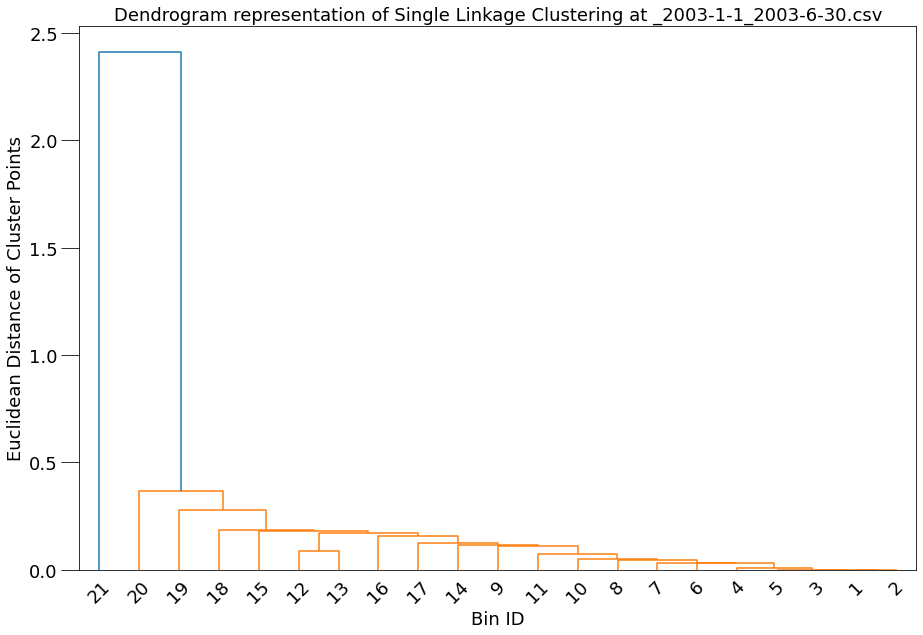

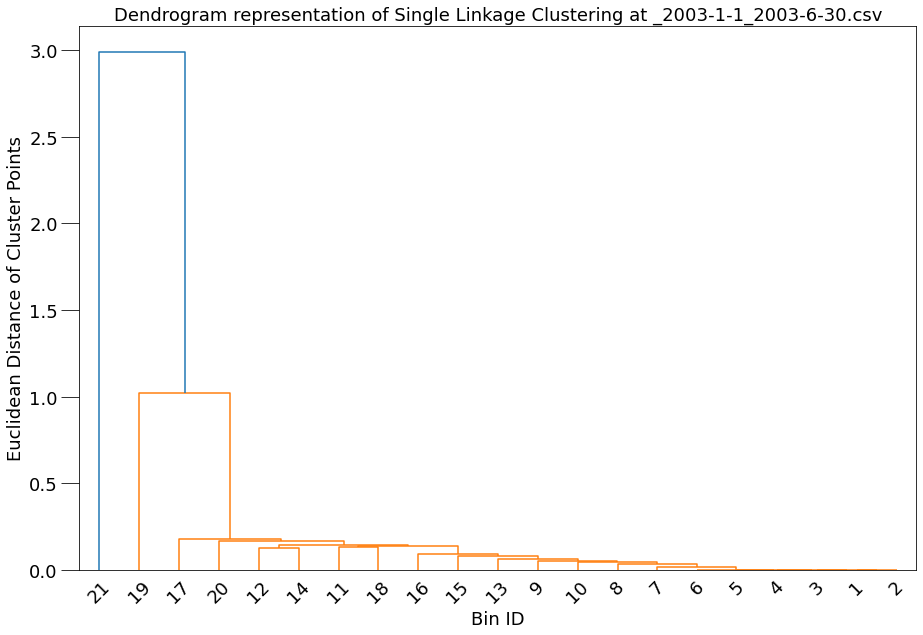

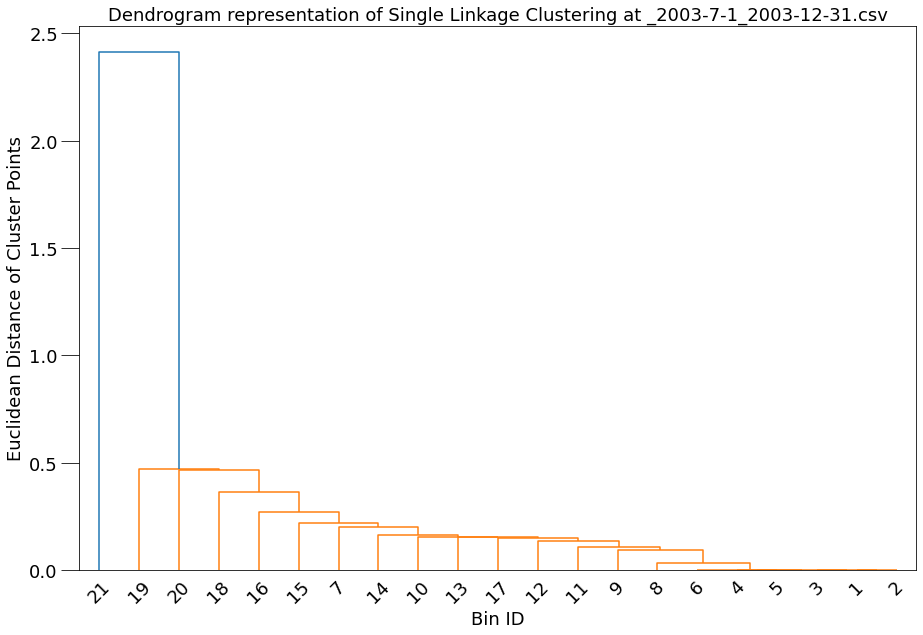

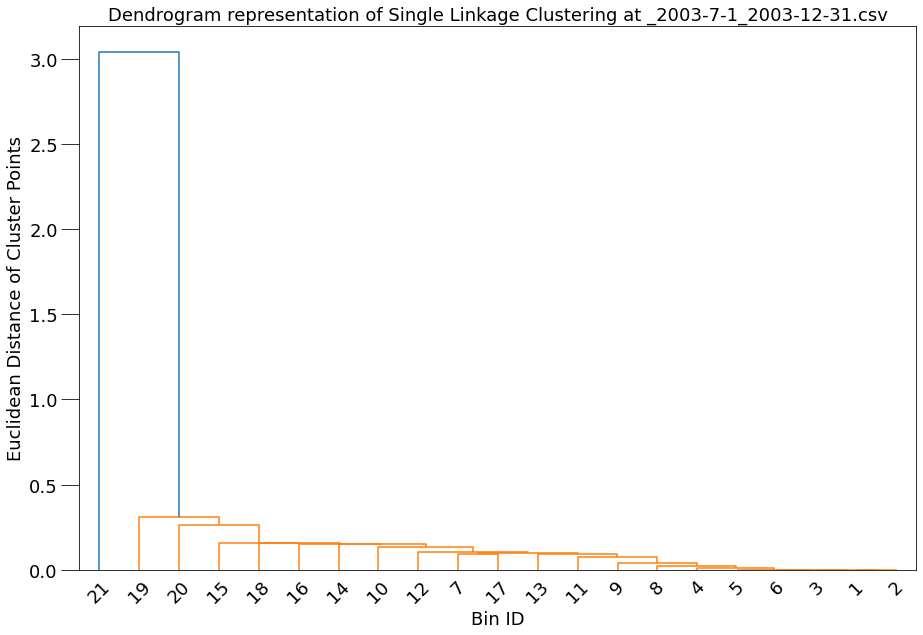

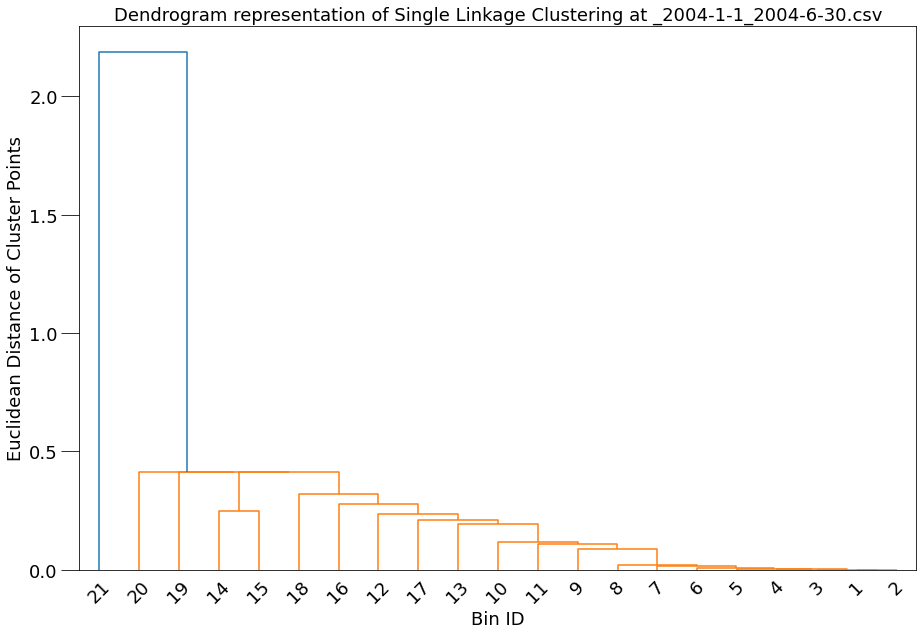

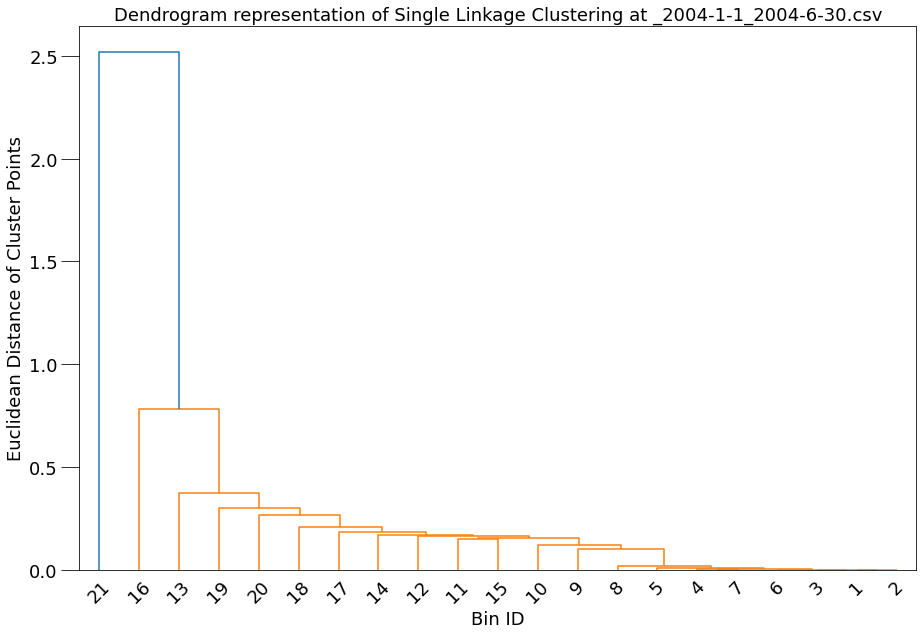

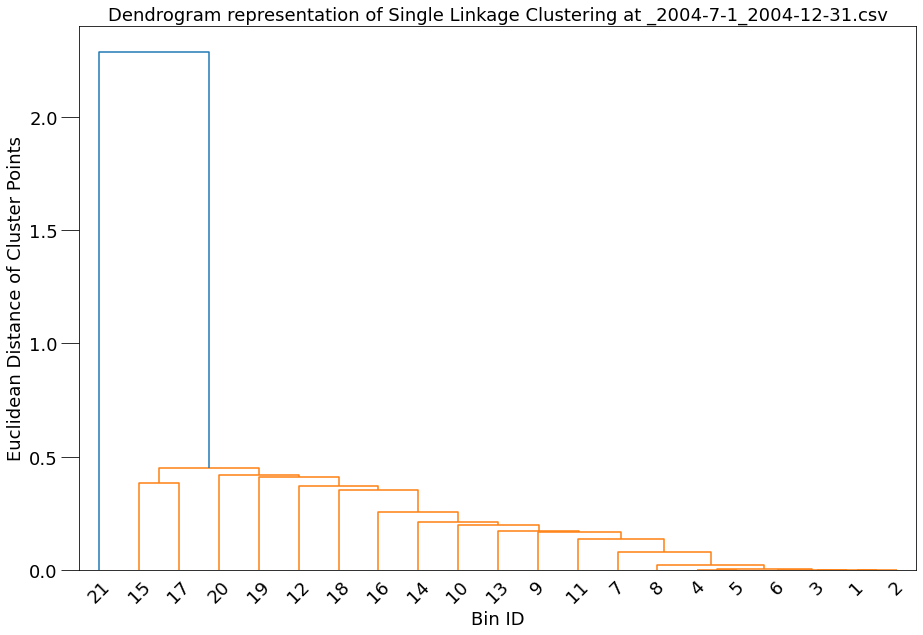

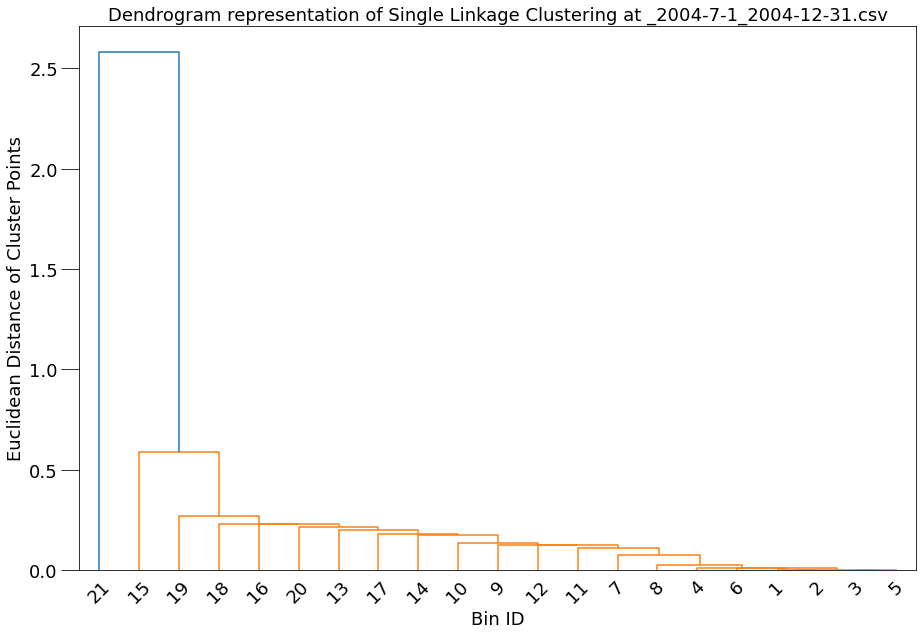

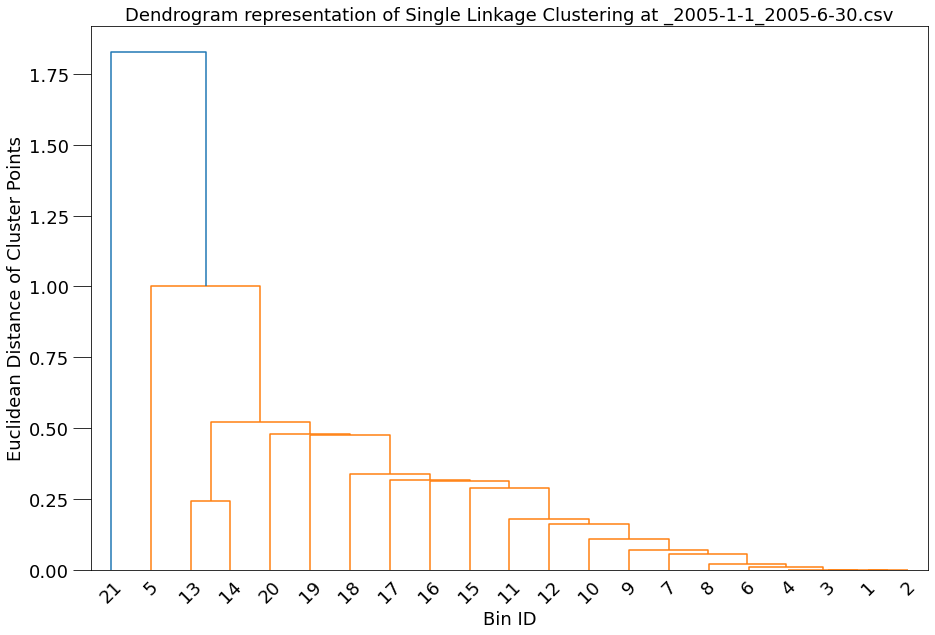

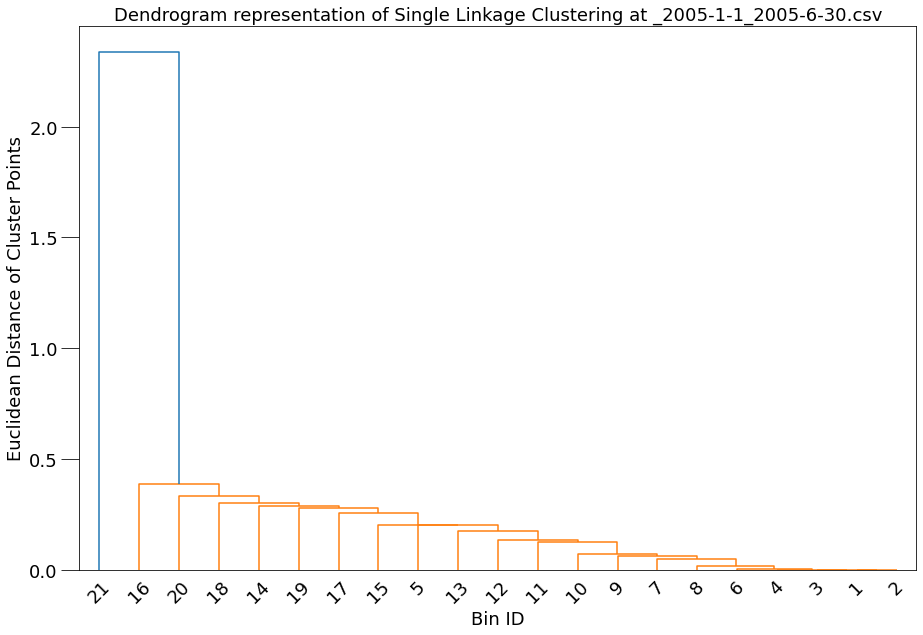

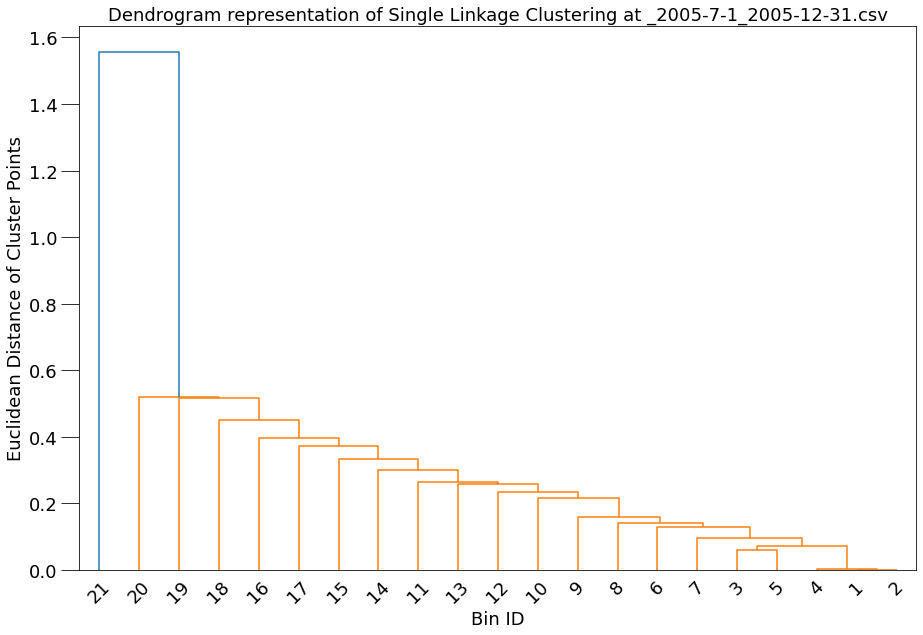

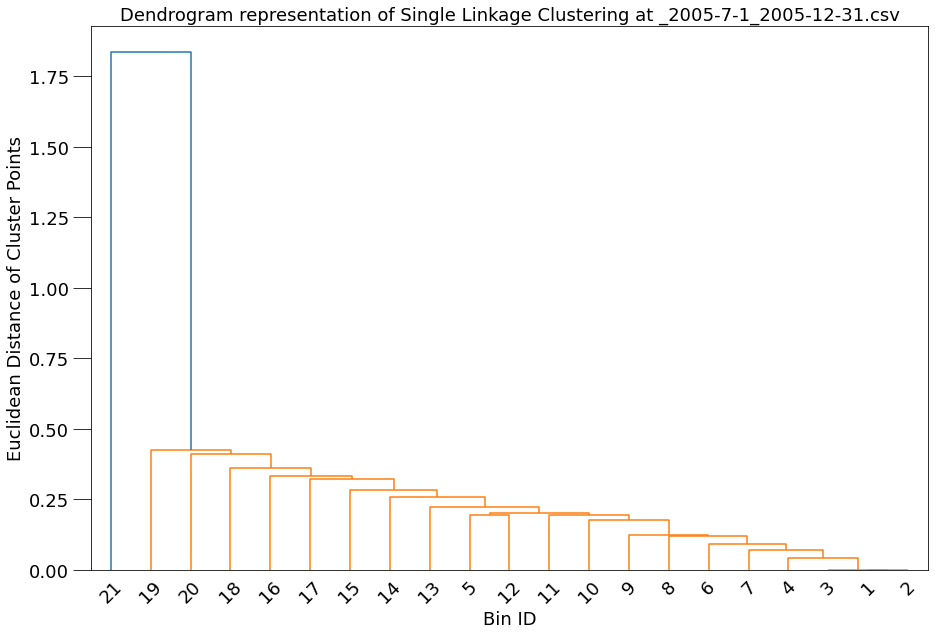

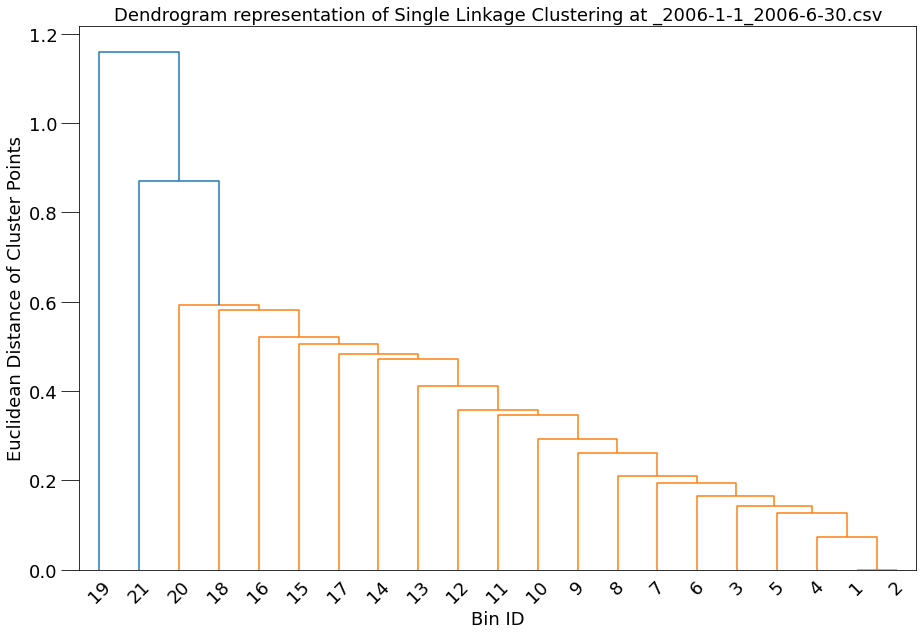

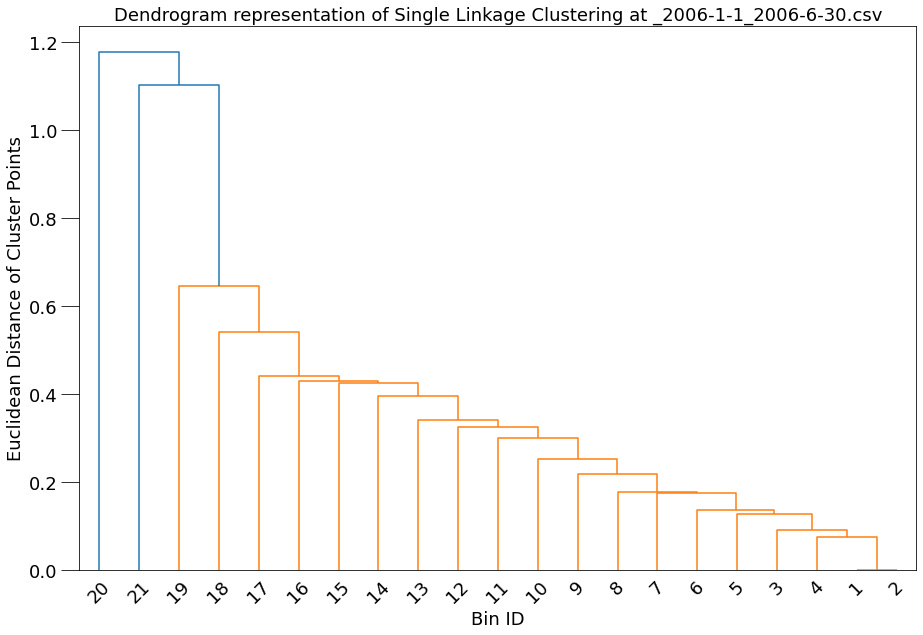

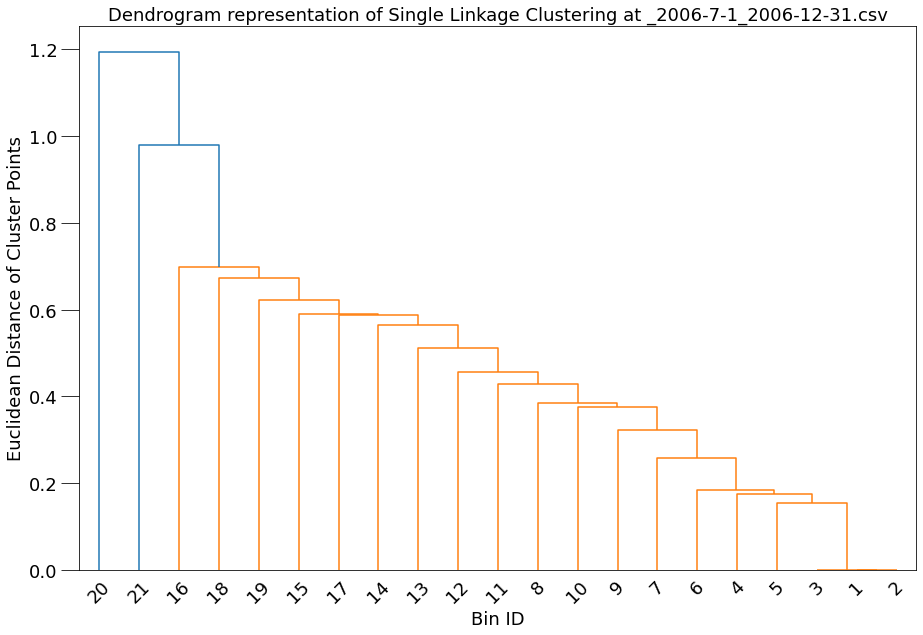

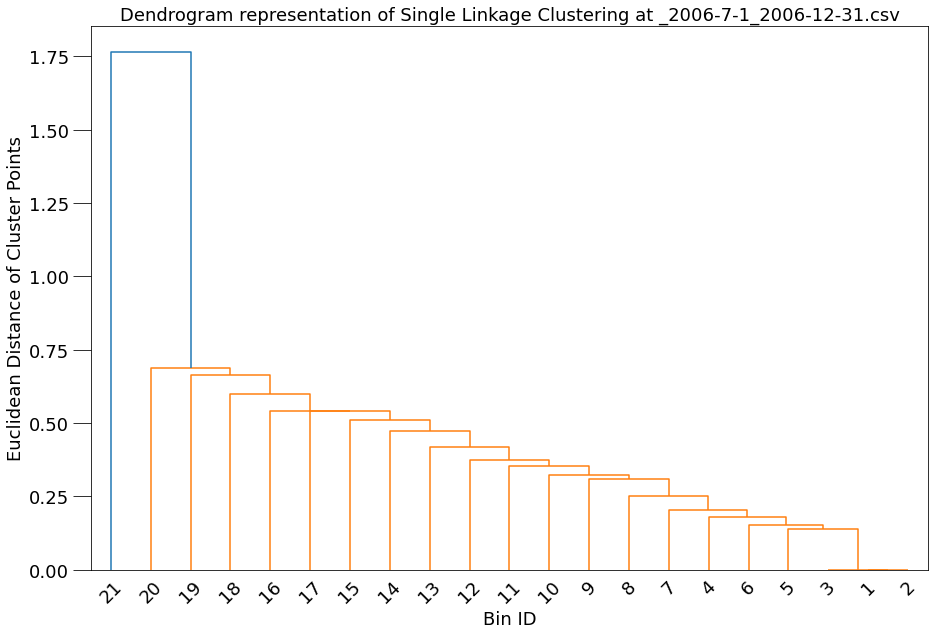

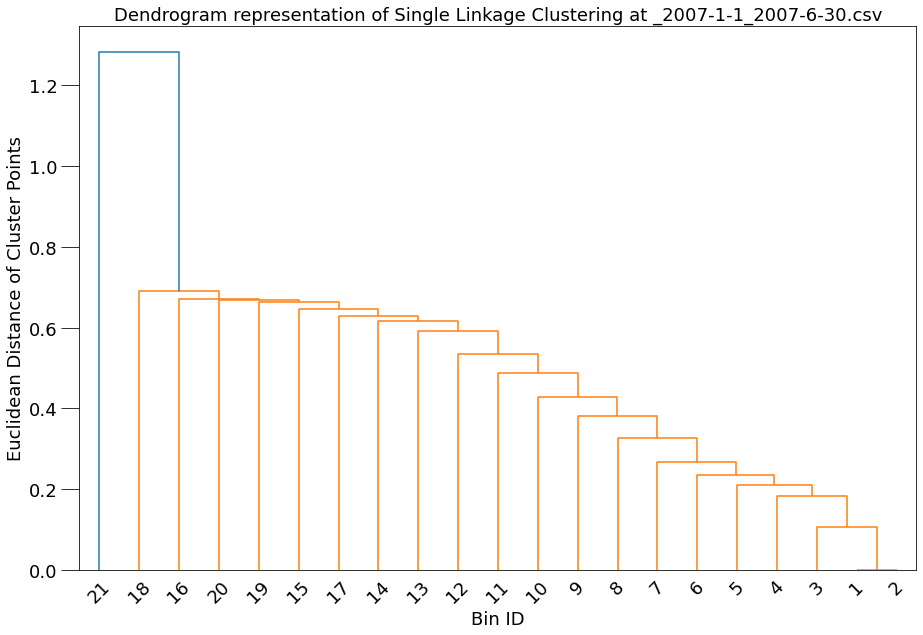

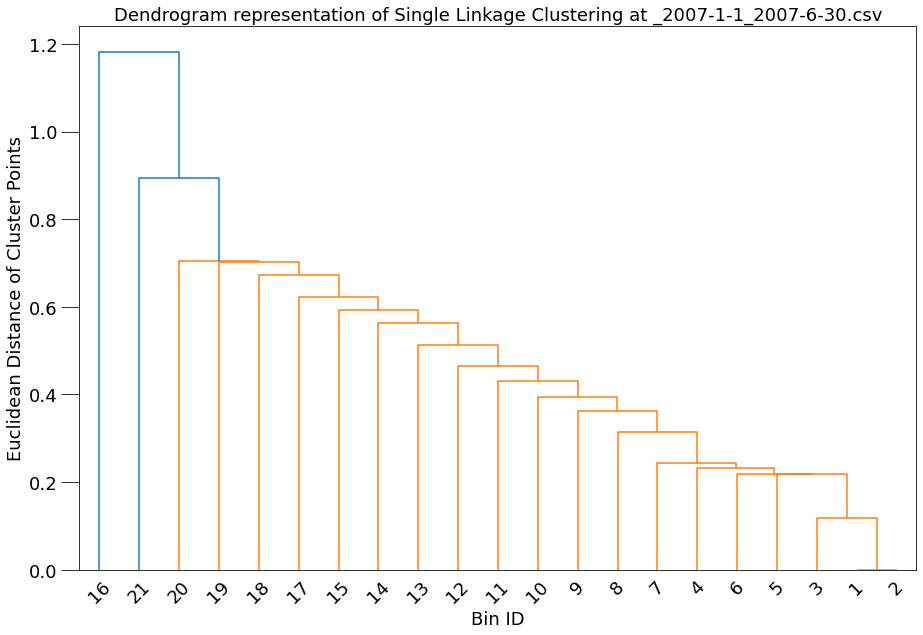

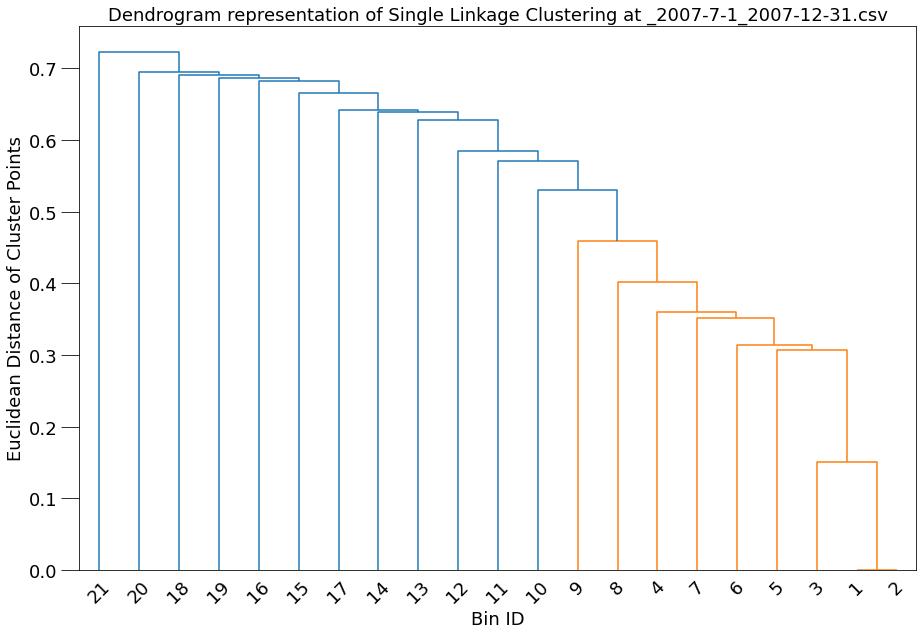

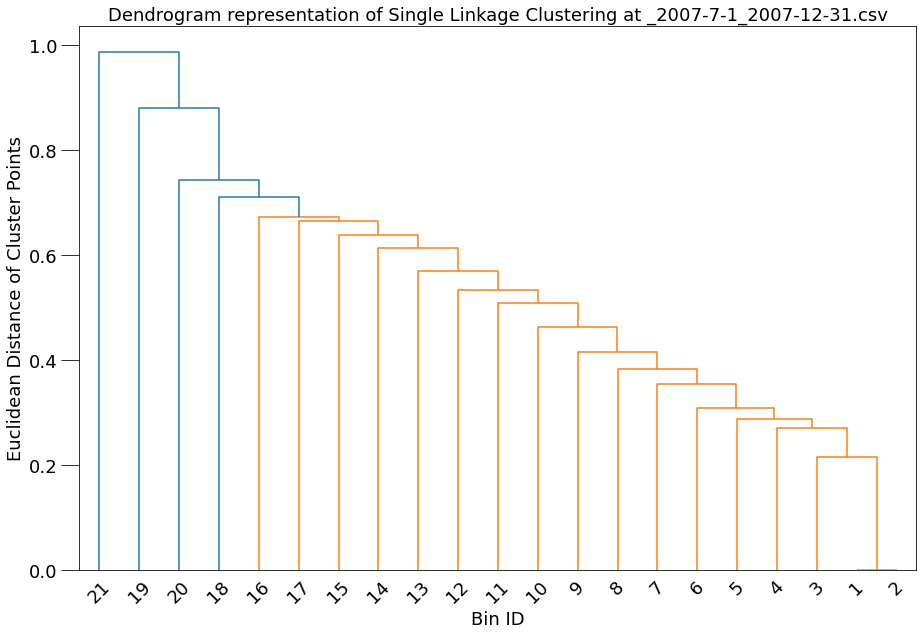

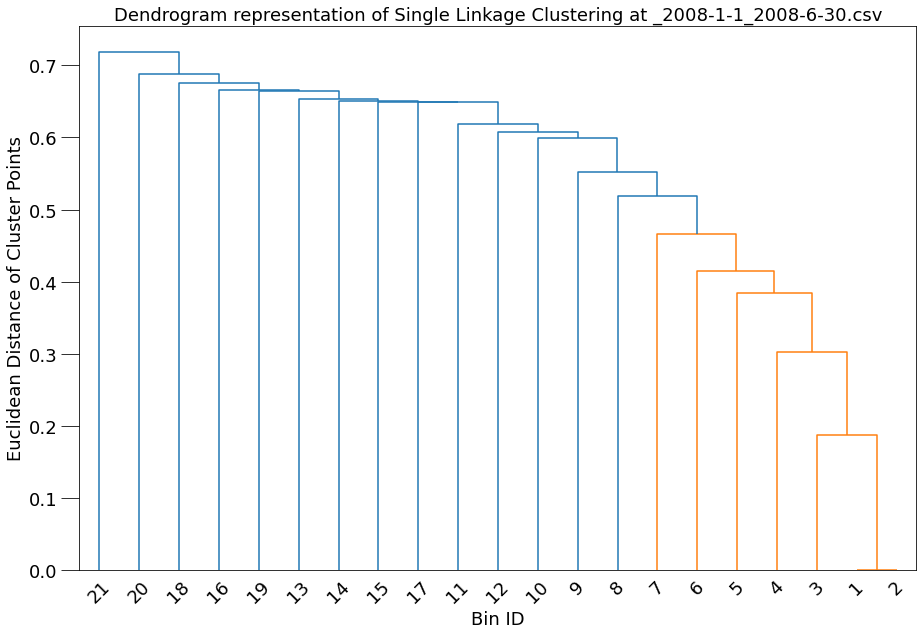

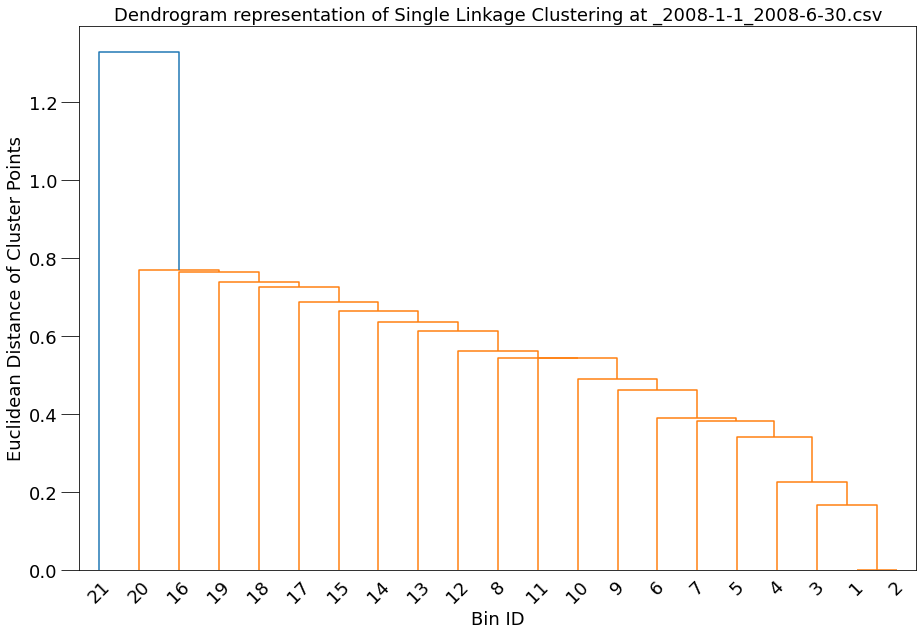

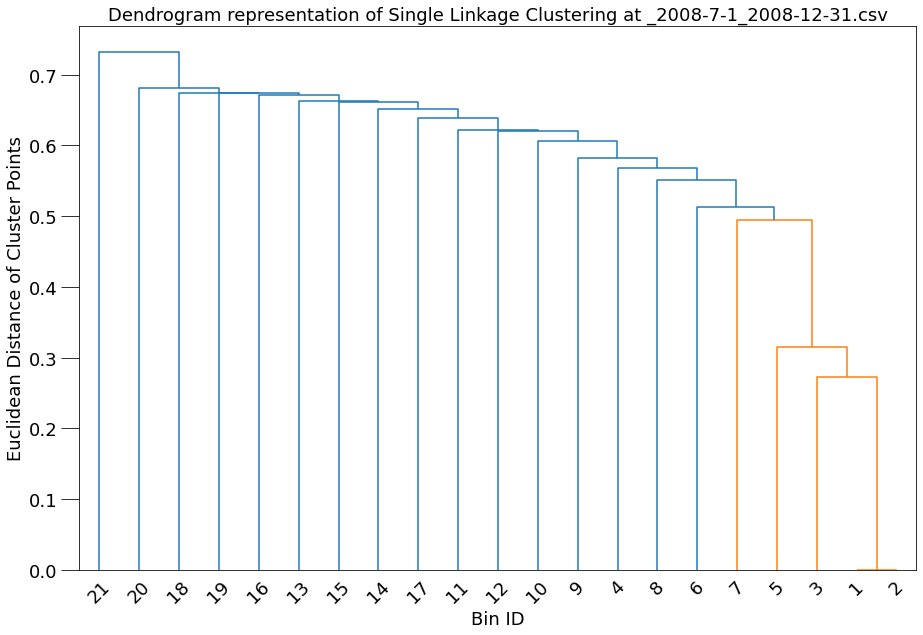

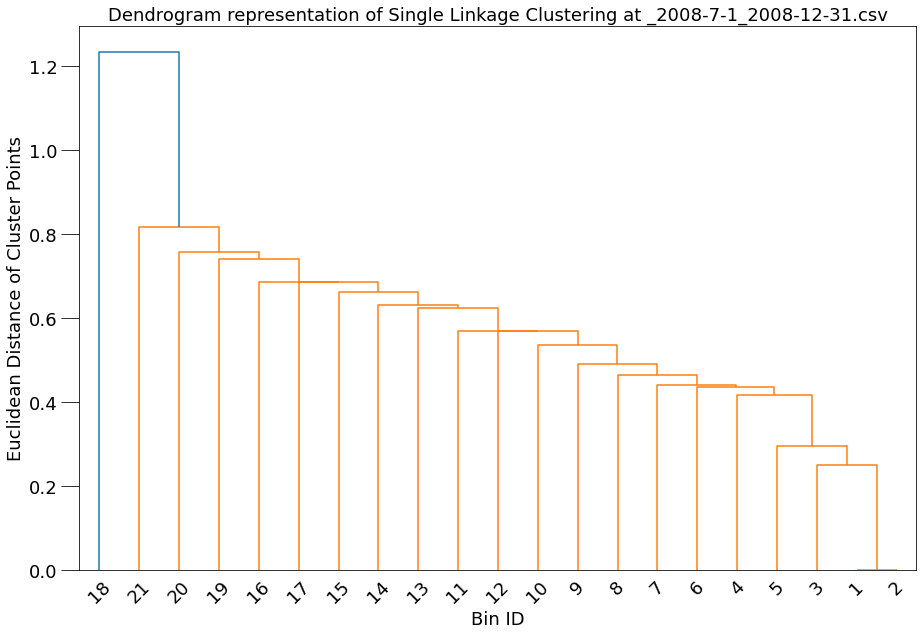

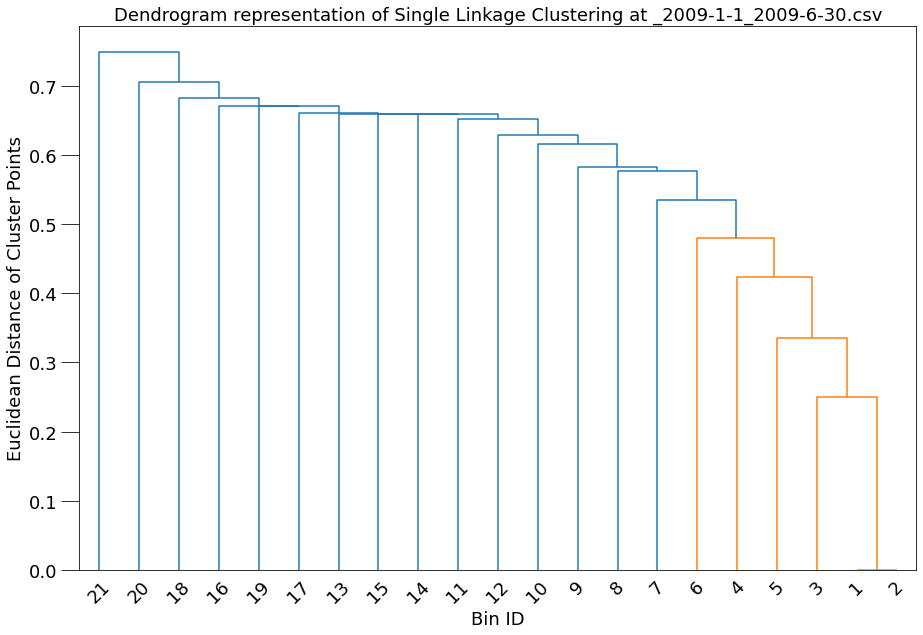

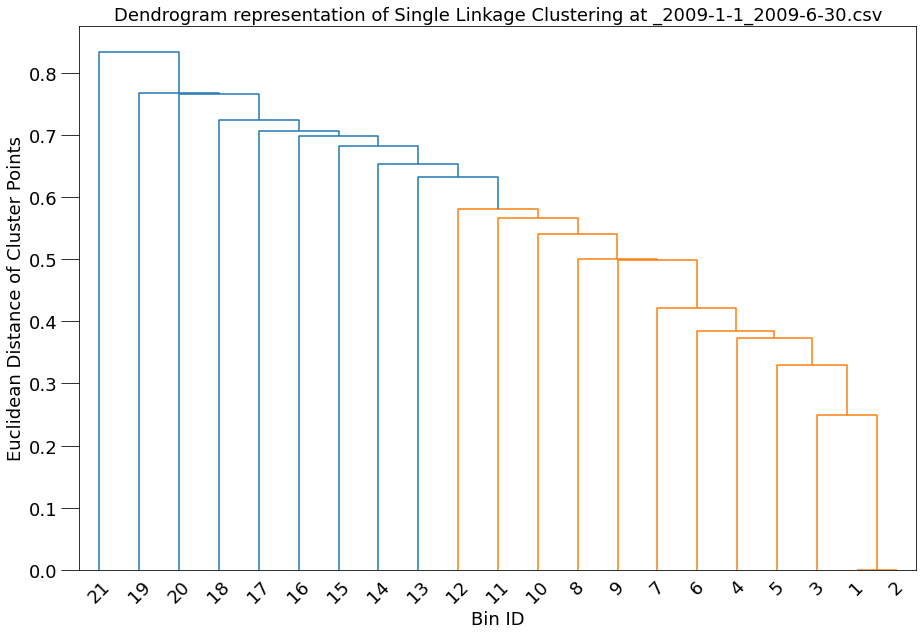

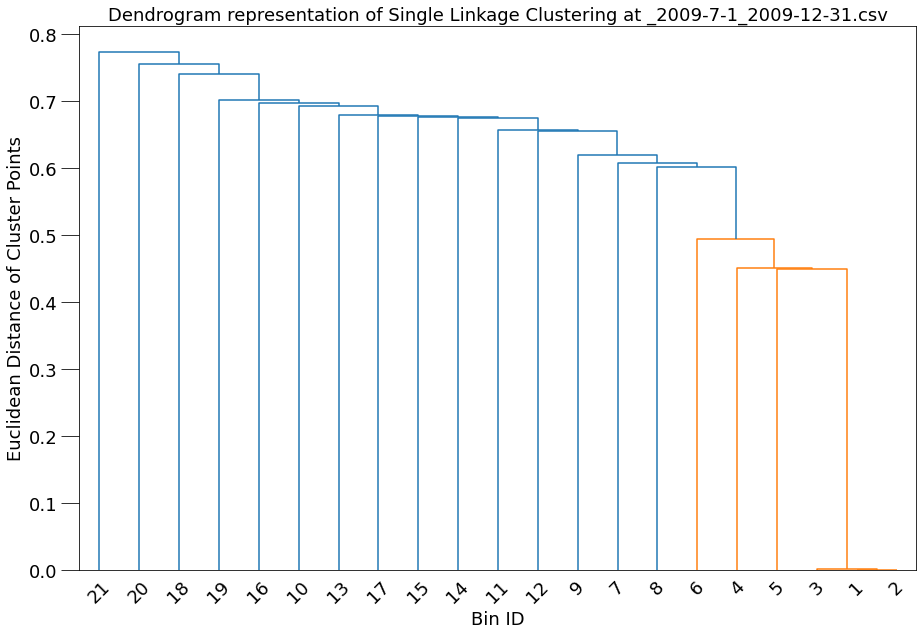

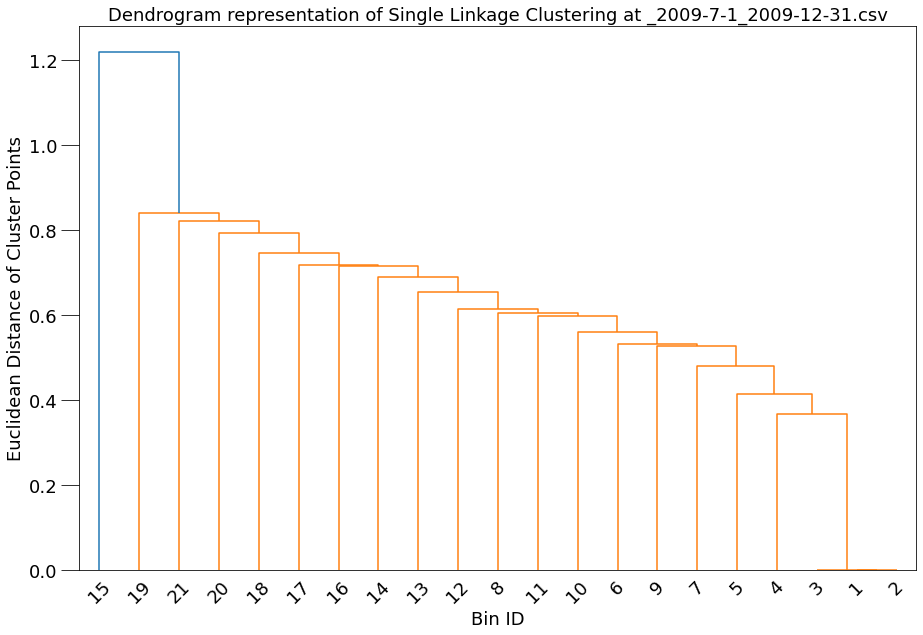

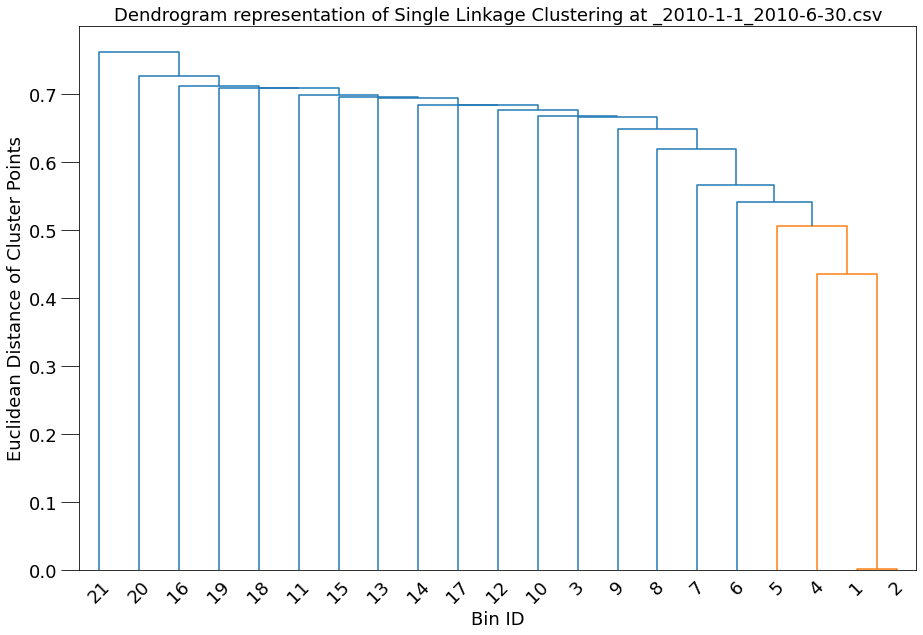

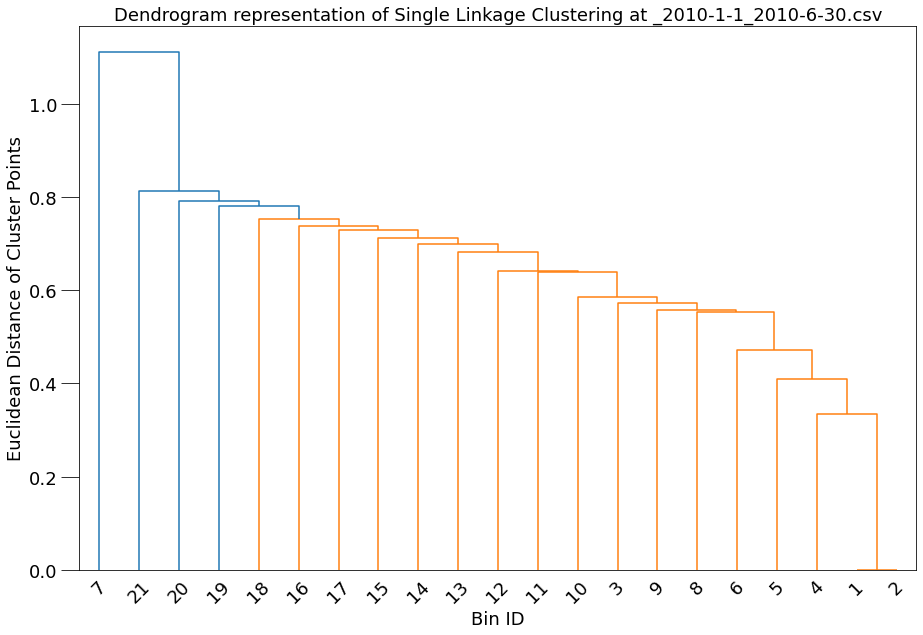

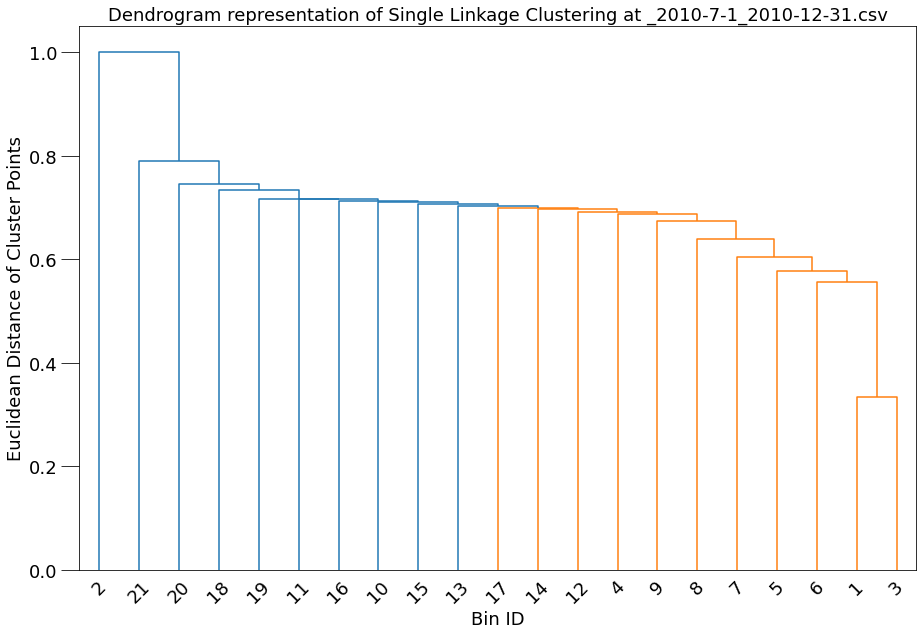

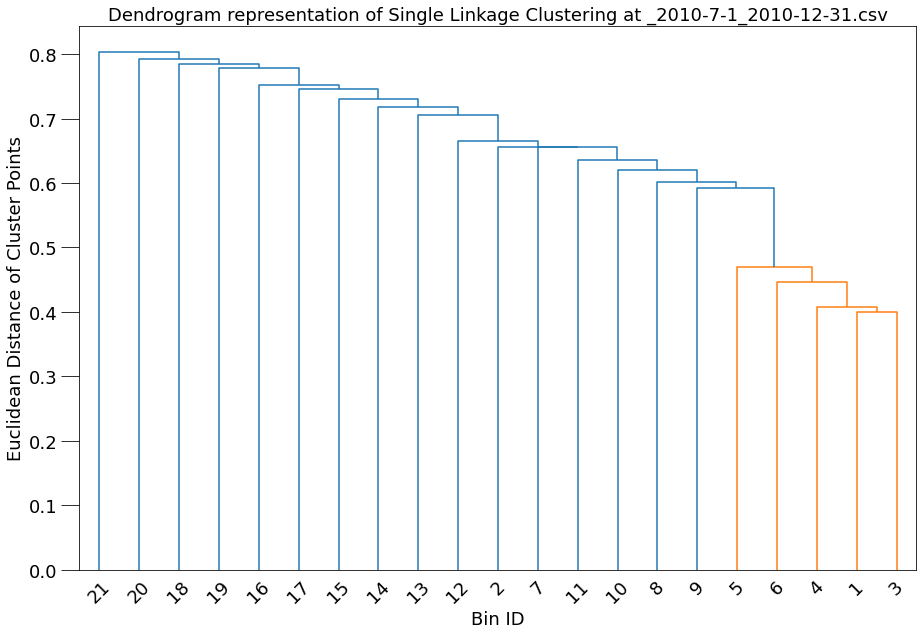

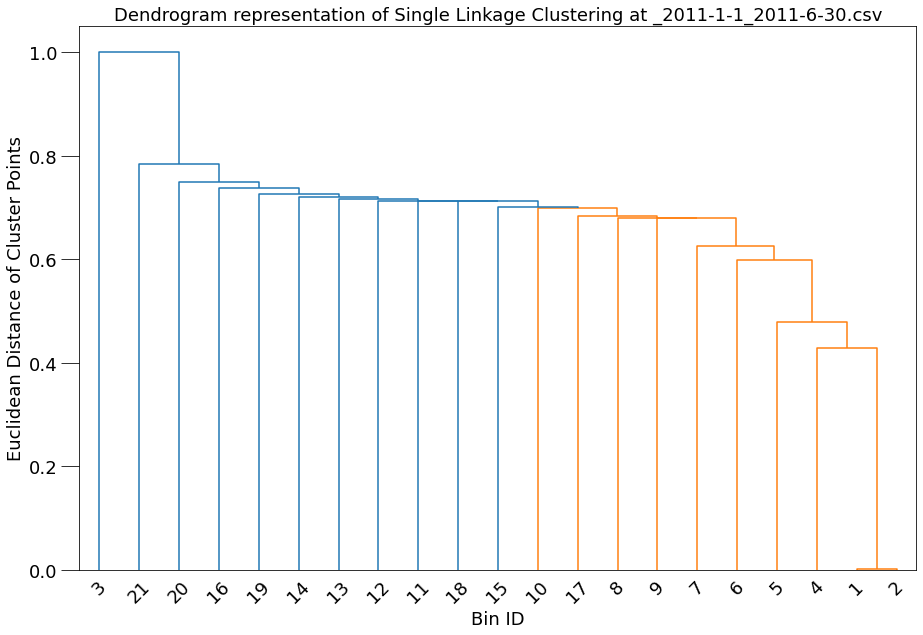

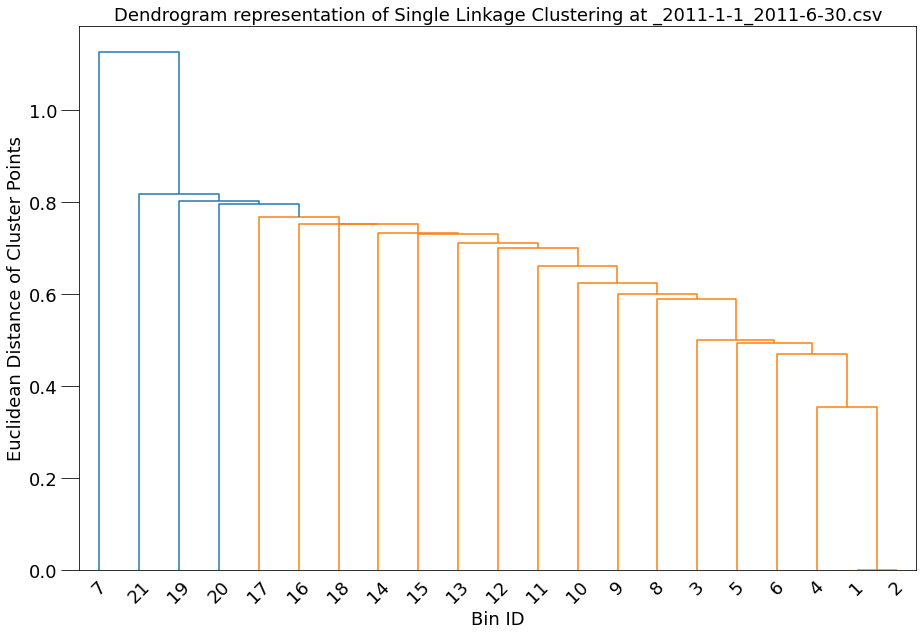

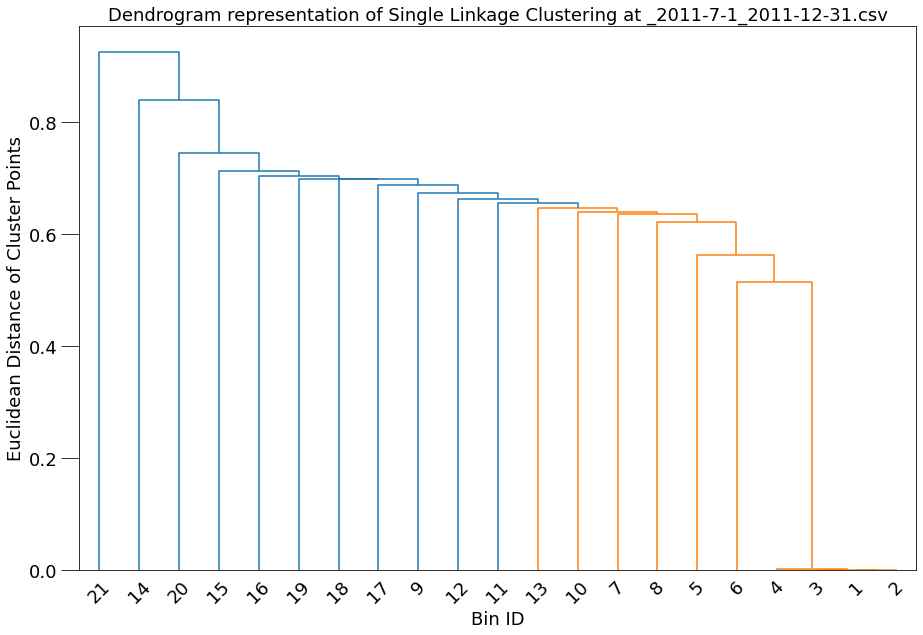

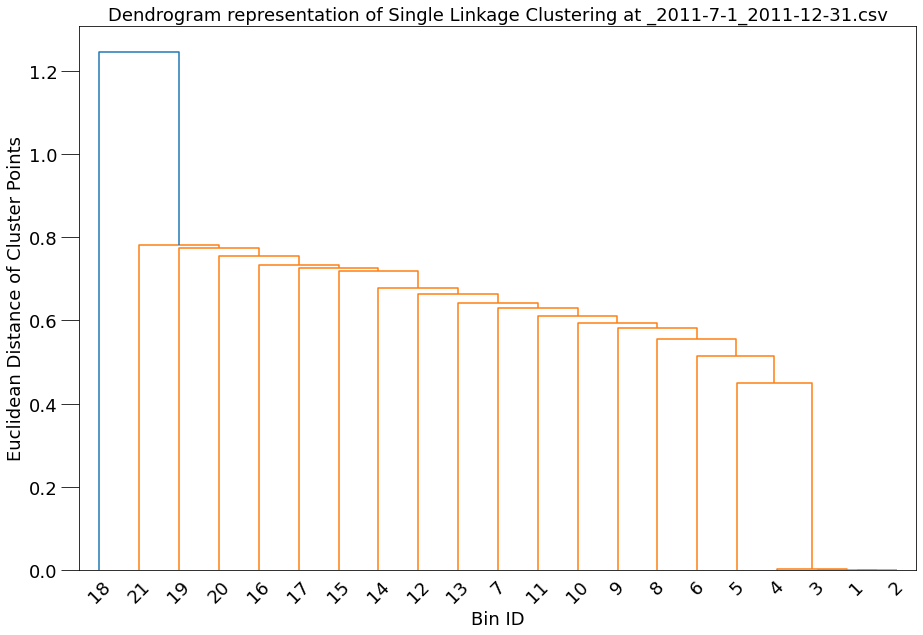

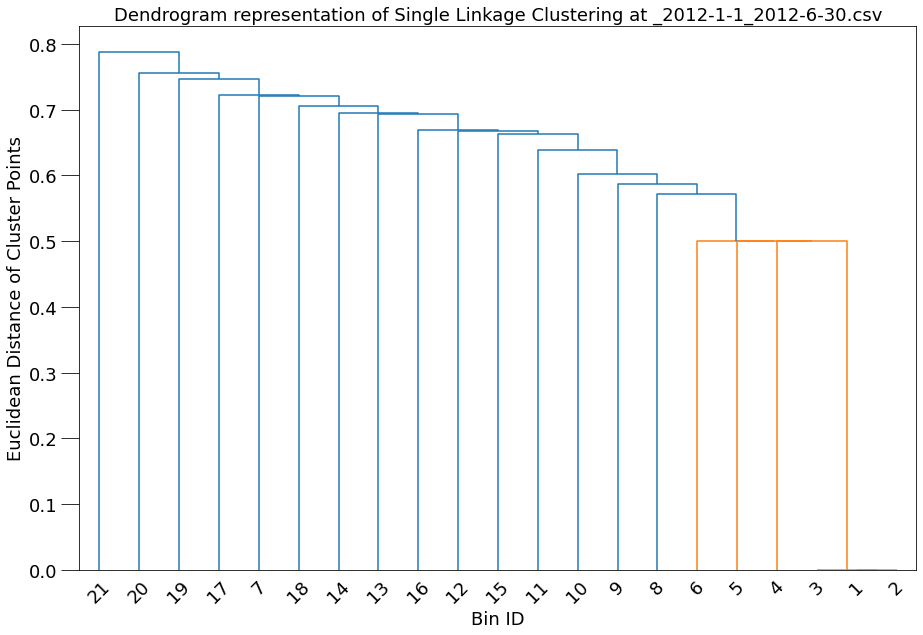

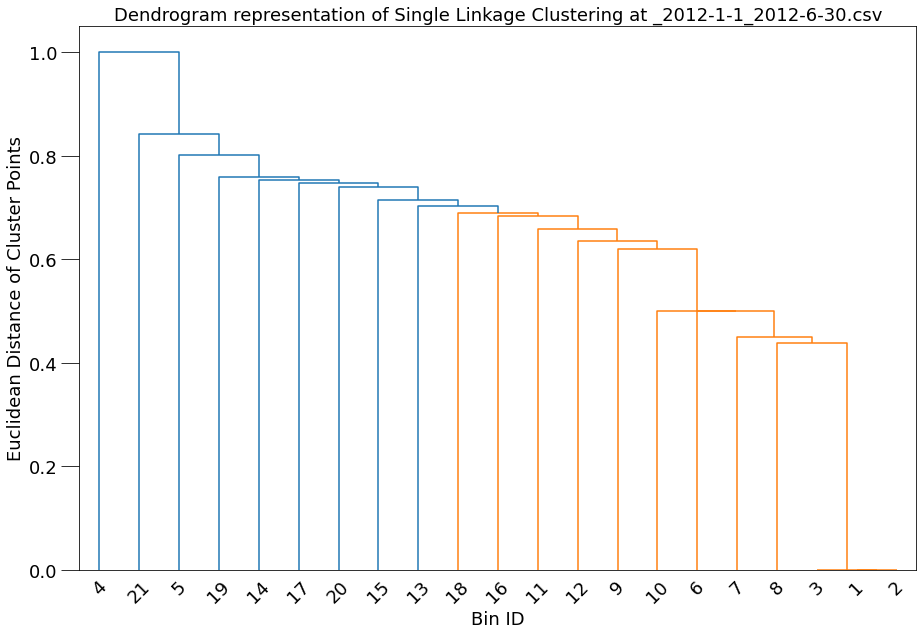

In [12]:
name_base = "matrix_binned_21bin"
all_columns = df_filtered['Bin'].unique()
hierarchyDiff = {'source': {}, 'target': {}}
clusterDist = {'source': {}, 'target': {}}

dm = 6

rec_norms = []
inv_norms = []
rec_obs = []
inv_obs = []
source_dendro = []
target_dendro = []
i = 0
for year in range(2003, 2013, 1):
    for month in range(1, 13, dm):
        if (year == 2012) and (month >= 7):
            break
        endday = 31
        print('{}-{}-{}'.format(year, month, i))
        i+=1
        if ( (month + dm-1) == 2) and (((year % 4) == 0) and ((year % 100) == 0) and ((year % 400) == 0)):
            endday = 29
        elif ((month +dm -1) == 2):
            endday = 28
        elif (month + dm - 1) in [4, 6, 9, 11]:
            endday = 30
        
        year_dict = {"start": year, "end": year}
        month_dict = {"start": month, "end": month + dm-1}
        day_dict = {"start": 1, "end": endday}
        
        df_timeslice = getTimeSlicedData(year_dict, 
                                         month_dict, 
                                         day_dict)
        

        date_tag = ('_{}-{}-{}_{}-{}-{}.csv'
                 .format(year_dict['start'], month_dict['start'], day_dict['start'],
                         year_dict['end'], month_dict['end'], day_dict['end']))
        
        unnormed_rec, norm_rec = getInvMatrix(df_timeslice, all_columns, "Bin", "InvitorBin")
        unnormed_inv, norm_inv = getInvMatrix(df_timeslice, all_columns, "InvitorBin", "Bin")
        
        normed_recObs = np.divide(unnormed_rec, norm_rec.transpose())
        normed_invObs = np.divide(unnormed_inv, norm_inv.transpose())
        
        rec_norms.append(norm_rec)
        inv_norms.append(norm_inv)
        rec_obs.append(normed_recObs)
        inv_obs.append(normed_invObs)
        source_dendro.append(linkage(normed_recObs.values.T, 'single'))
        target_dendro.append(linkage(normed_invObs.values.T, 'single'))
        
        #plotMatrix(normed_recObs.values, name_base+"_rec", date_tag, invitor_y = False)
        #plotMatrix(normed_invObs.values, name_base+"_inv", date_tag, invitor_y = True)
        #plotNorm(norm_rec, name_base+"_rec_norm", date_tag, False)
        #plotNorm(norm_inv, name_base+"_inv_norm", date_tag, False)

        # If the invitors are observed originally, in the transpose of it, the receivers will be the observed
        thd, tcd = createDendrogram(normed_invObs.values.T, name_base+'_dendogram_target', date_tag)
        shd, scd = createDendrogram(normed_recObs.values.T, name_base+'_dendogram_source', date_tag)

        hierarchyDiff['source'][date_tag] = shd
        hierarchyDiff['target'][date_tag] = thd
        clusterDist['source'][date_tag] = scd
        clusterDist['target'][date_tag] = tcd

In [29]:
inv_obs[6]

Bin                1    2         3         4         5         6         7  \
InvitorBin                                                                    
1           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
2           0.000000  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
3           0.000000  0.0  0.142857  0.000000  0.000000  0.000000  0.000000   
4           0.000000  0.0  0.000000  0.073171  0.000000  0.048780  0.073171   
5           0.000000  0.0  0.000000  0.000000  0.126984  0.007937  0.007937   
6           0.000000  0.0  0.000000  0.002890  0.002890  0.164740  0.017341   
7           0.000000  0.0  0.000000  0.000000  0.000000  0.007165  0.192426   
8           0.000000  0.0  0.000000  0.000531  0.001061  0.005836  0.010610   
9           0.000000  0.0  0.000000  0.000288  0.001153  0.003749  0.007497   
10          0.000000  0.0  0.000000  0.000160  0.000799  0.002396  0.005272   
11          0.000000  0.0  0.000130  0.000130  0.000259  0.001297  0.004279   
12          0.000000  0.0  0.000116  0.000231  0.000925  0.002313  0.003353   
13          0.000000  0.0  0.000000  0.000219  0.000110  0.001207  0.002962   
14          0.000000  0.0  0.000000  0.000214  0.000500  0.000714  0.003715   
15          0.000000  0.0  0.000063  0.000314  0.000251  0.001005  0.002888   
16          0.000000  0.0  0.000000  0.000053  0.000474  0.001264  0.002264   
17          0.000000  0.0  0.000123  0.000000  0.000246  0.001846  0.002338   
18          0.000000  0.0  0.000053  0.000158  0.000841  0.001945  0.007044   
19          0.000000  0.0  0.000034  0.000103  0.000412  0.001784  0.004769   
20          0.000042  0.0  0.000000  0.000125  0.000208  0.000458  0.001709   
21          0.000000  0.0  0.000033  0.000083  0.000273  0.000970  0.002080   

Bin                8         9        10  ...        12        13        14  \
InvitorBin                                ...                                 
1           0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
2           0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
3           0.000000  0.000000  0.142857  ...  0.142857  0.000000  0.142857   
4           0.024390  0.024390  0.024390  ...  0.024390  0.048780  0.024390   
5           0.023810  0.055556  0.055556  ...  0.039683  0.047619  0.055556   
6           0.014451  0.040462  0.020231  ...  0.026012  0.052023  0.063584   
7           0.021494  0.033777  0.028659  ...  0.026612  0.027636  0.053224   
8           0.203183  0.030769  0.029708  ...  0.034483  0.038196  0.061538   
9           0.015283  0.242503  0.033160  ...  0.037486  0.036044  0.049308   
10          0.011661  0.021246  0.268530  ...  0.030990  0.034505  0.045048   
11          0.008428  0.016468  0.028916  ...  0.031639  0.033325  0.047718   
12          0.008094  0.014801  0.028677  ...  0.336494  0.033302  0.046138   
13          0.008995  0.012835  0.024572  ...  0.030057  0.390193  0.035761   
14          0.007431  0.013504  0.020149  ...  0.025079  0.021435  0.436482   
15          0.006027  0.011050  0.021409  ...  0.024422  0.025490  0.030136   
16          0.006846  0.010690  0.028120  ...  0.023381  0.025698  0.036335   
17          0.007506  0.010951  0.024240  ...  0.030762  0.024732  0.027685   
18          0.012037  0.020238  0.025757  ...  0.024180  0.021604  0.037058   
19          0.010877  0.018871  0.026214  ...  0.028616  0.024910  0.037983   
20          0.005001  0.007168  0.017628  ...  0.034714  0.033297  0.027380   
21          0.003804  0.007293  0.013733  ...  0.020264  0.024532  0.039375   

Bin               15        16        17        18        19        20  \
InvitorBin                                                               
1           0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2           0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
3           0.000000  0.142857  0.000000  0.142857  0.000000  0.0000

In [30]:
rec_obs[6].sum(axis = 1)

Bin
1     1.0
2     0.0
3     1.0
4     1.0
5     1.0
6     1.0
7     1.0
8     1.0
9     1.0
10    1.0
11    1.0
12    1.0
13    1.0
14    1.0
15    1.0
16    1.0
17    1.0
18    1.0
19    1.0
20    1.0
21    1.0
dtype: float64

<ipython-input-23-f3135852b2af>:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(rec_obs[6].values))


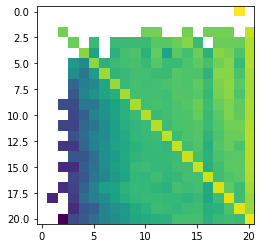

In [23]:
plt.imshow(np.log10(rec_obs[6].values))

# Plot invitation matrix norms

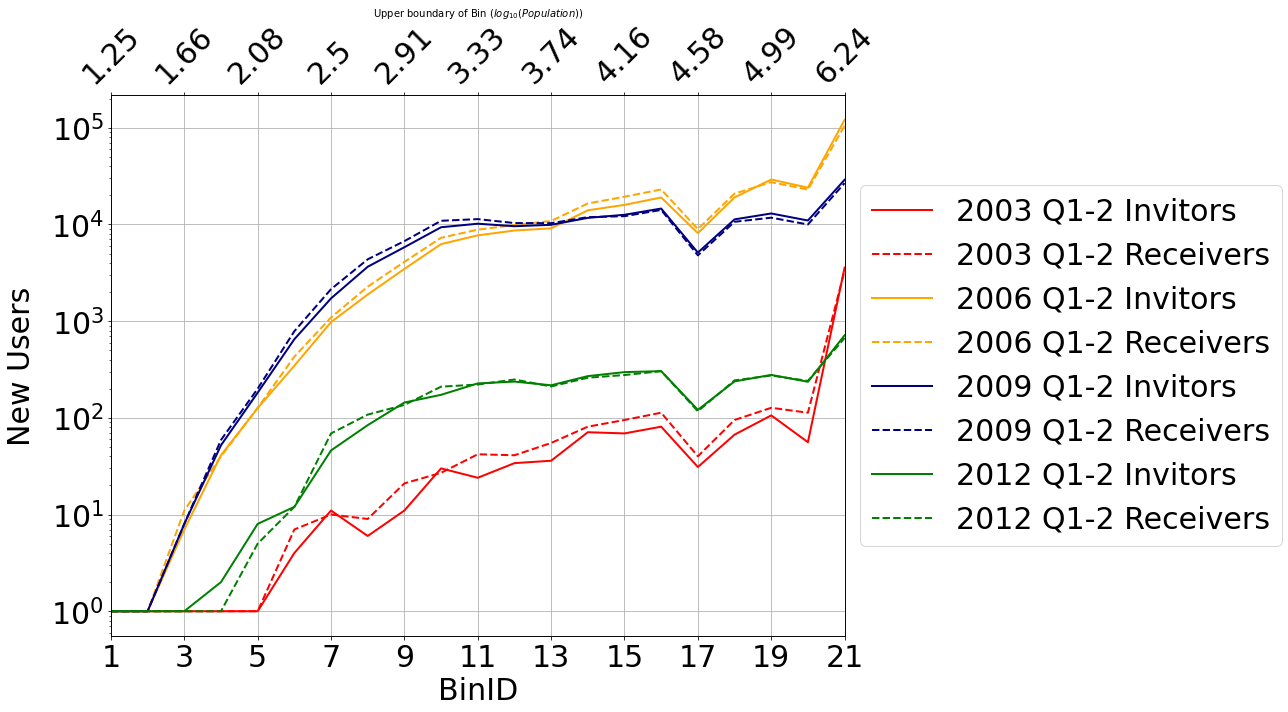

In [13]:
colors = ['red', 'orange', 'navy', 'green']
labels = ['2003 Q1-2', '2006 Q1-2', '2009 Q1-2', '2012 Q1-2']
#upper_bin_sizes = list(map(int, np.sort(np.round(np.power(10, np.multiply(list(origBin_to_goodBin.keys()), bw)), 0))))
upper_bin_sizes = np.sort(np.round(np.multiply(list(origBin_to_goodBin.keys()), bw), 2))
fig, ax1 = plt.subplots(1, 1, figsize = (18, 10))
plt.ylabel('New Users', fontsize = 30, labelpad = 15)
plt.yticks(fontsize = 30)
ax1.set_xticks(range(1, 22, 2))
ax1.set_xticklabels(range(1, 22, 2), fontsize = 30)
ax1.set_xlabel('BinID', fontsize = 30)
ax1.set_xlim(1, 21)

ax2 = ax1.twiny()
ax2.set_xticks(range(1, 22, 2))
ax2.set_xticklabels(upper_bin_sizes[0::2], rotation = 45, fontsize = 30)
ax2.set_xlabel(r'Upper boundary of Bin ($log_{10}(Population)$)')
ax2.set_xlim(ax1.get_xlim())

for i, c, l in zip(range(0, len(inv_norms), 6), colors, labels):
    ax1.plot(np.array(inv_norms[0].columns, dtype = int), 
             inv_norms[i].values[0], 
             label =  l + ' Invitors',
             color = c, linewidth = 2)
    
    ax1.plot(np.array(rec_norms[0].columns, dtype = int), 
         rec_norms[i].values[0], 
         '--',
         label = l +' Receivers',
         color = c, linewidth = 2)
         
plt.yscale('log')
ax1.legend(fontsize = 30, bbox_to_anchor=(1.0, 0.5), loc='center left')
ax1.grid()

plt.tight_layout()
plt.savefig('./plots_out/norms.pdf')

# Plot Invitation matrices - Subfigures, final

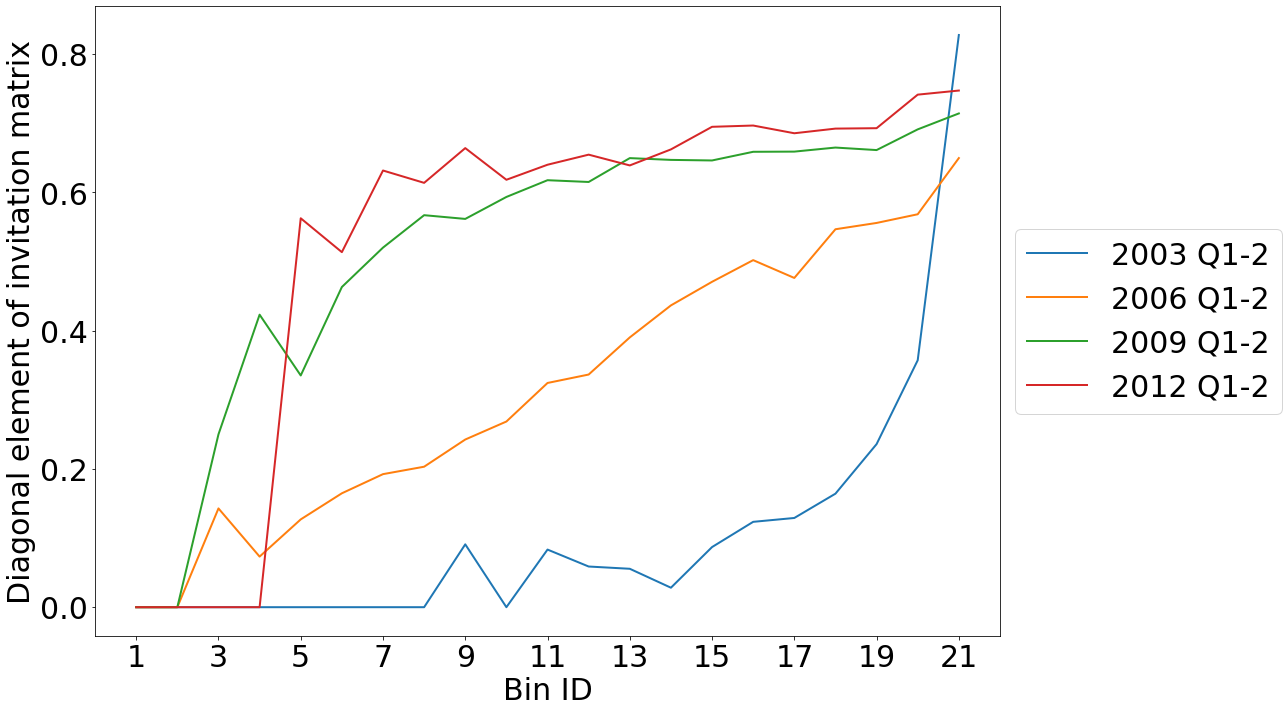

In [14]:
arr = inv_obs

plt.figure(figsize = (18, 10))
plt.plot(range(1, arr[0].shape[0]+1), arr[0].values.diagonal(), label = '2003 Q1-2', linewidth = 2)
plt.plot(range(1, arr[6].shape[0]+1), arr[6].values.diagonal(), label = '2006 Q1-2', linewidth = 2)
plt.plot(range(1, arr[12].shape[0]+1), arr[12].values.diagonal(), label = '2009 Q1-2', linewidth = 2)
plt.plot(range(1, arr[17].shape[0]+1), arr[17].values.diagonal(), label = '2012 Q1-2', linewidth = 2)
plt.xticks(range(1, arr[0].shape[0]+1, 2), fontsize = 30)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30, bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.xlabel('Bin ID', fontsize = 30)
plt.ylabel('Diagonal element of invitation matrix', fontsize = 30)
plt.tight_layout()
plt.savefig('./plots_out/invmat_diag.pdf')

<ipython-input-15-3d76d313457a>:1: RuntimeWarning: divide by zero encountered in log10
  min_val = min(np.nanmin(np.log10(arr[0]).values[np.log10(arr[0].values) != -np.inf]),
<ipython-input-15-3d76d313457a>:2: RuntimeWarning: divide by zero encountered in log10
  np.nanmin(np.log10(arr[6]).values[np.log10(arr[6].values) != -np.inf]),
<ipython-input-15-3d76d313457a>:3: RuntimeWarning: divide by zero encountered in log10
  np.nanmin(np.log10(arr[12]).values[np.log10(arr[12].values) != -np.inf]),
<ipython-input-15-3d76d313457a>:4: RuntimeWarning: divide by zero encountered in log10
  np.nanmin(np.log10(arr[18]).values[np.log10(arr[18].values) != -np.inf]))
<ipython-input-15-3d76d313457a>:5: RuntimeWarning: divide by zero encountered in log10
  max_val = max(np.max(np.log10(arr[0].values)),
<ipython-input-15-3d76d313457a>:6: RuntimeWarning: divide by zero encountered in log10
  np.max(np.log10(arr[6].values)),
<ipython-input-15-3d76d313457a>:7: RuntimeWarning: divide by zero encountered in

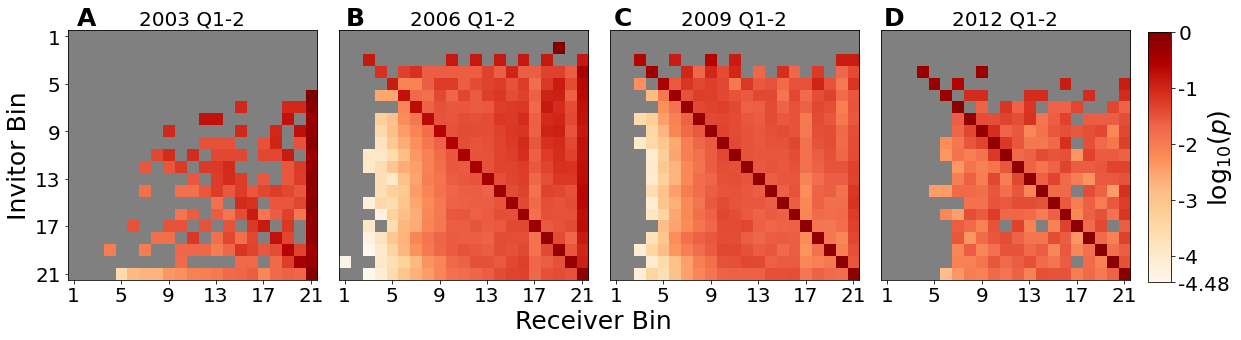

In [15]:
min_val = min(np.nanmin(np.log10(arr[0]).values[np.log10(arr[0].values) != -np.inf]),
                np.nanmin(np.log10(arr[6]).values[np.log10(arr[6].values) != -np.inf]),
                np.nanmin(np.log10(arr[12]).values[np.log10(arr[12].values) != -np.inf]),
                np.nanmin(np.log10(arr[18]).values[np.log10(arr[18].values) != -np.inf]))
max_val = max(np.max(np.log10(arr[0].values)), 
                np.max(np.log10(arr[6].values)),
                np.max(np.log10(arr[12].values)),
                np.max(np.log10(arr[18].values)))

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(1, 4, figsize = (16, 6))
fig.subplots_adjust(wspace= 0.05)
fs = 20
label_fs = 25
label_y = 0.8

current_cmap = matplotlib.cm.get_cmap('OrRd')
current_cmap.set_bad(color='Gray')

plot1 = ax1.imshow(np.log10(arr[0].values), cmap = current_cmap, vmin = min_val, 
                                                              vmax = max_val)
ax1.set_title("2003 Q1-2", fontsize = fs)
#ax1.set_xlabel('Receiver Bin', fontsize = fs)
ax1.set_ylabel('Invitor Bin', fontsize = label_fs)
ax1.set_xticks(range(0, 21, 4))
ax1.set_xticklabels(range(1, 22, 4), fontsize = fs)
ax1.set_yticks(range(0, 21, 4))
ax1.set_yticklabels(range(1, 22, 4), fontsize = fs)
fig.text(0.07, label_y, 'A', fontweight = 'bold', fontsize = label_fs)

ax2.imshow(np.log10(arr[6].values), cmap = 'OrRd', vmin = min_val, 
                                                      vmax = max_val)
ax2.set_title("2006 Q1-2", fontsize = fs)
#ax2.set_xlabel('Receiver Bin', fontsize = fs)
#ax2.set_ylabel('Invitor Bin', fontsize = fs)
ax2.set_xticks(range(0, 21, 4))
ax2.set_xticklabels(range(1, 22, 4), fontsize = fs)
ax2.set_yticks(range(0, 21, 4))
ax2.set_yticklabels(range(1, 22, 4), fontsize = fs)
ax2.get_yaxis().set_visible(False)
fig.text(0.303, label_y, 'B', fontweight = 'bold', fontsize = label_fs)

ax3.imshow(np.log10(arr[12].values), cmap = 'OrRd', vmin = min_val, 
                                                      vmax = max_val)
ax3.set_title("2009 Q1-2", fontsize = fs)
#ax3.set_xlabel('Receiver Bin', fontsize = fs)
#ax3.set_ylabel('Invitor Bin', fontsize = fs)
ax3.set_xticks(range(0, 21, 4))
ax3.set_xticklabels(range(1, 22, 4), fontsize = fs)
ax3.set_yticks(range(0, 21, 4))
ax3.set_yticklabels(range(1, 22, 4), fontsize = fs)
ax3.get_yaxis().set_visible(False)
fig.text(0.536, label_y, 'C', fontweight = 'bold', fontsize = label_fs)

ax4.imshow(np.log10(arr[18].values), cmap = 'OrRd', vmin = min_val, 
                                                      vmax = max_val)
ax4.set_title("2012 Q1-2", fontsize = fs)
#ax4.set_xlabel('Receiver Bin', fontsize = fs)
#ax4.set_ylabel('Invitor Bin', fontsize = fs)
ax4.set_xticks(range(0, 21, 4))
ax4.set_xticklabels(range(1, 22, 4), fontsize = fs)
ax4.set_yticks(range(0, 21, 4))
ax4.set_yticklabels(range(1, 22, 4), fontsize = fs)
ax4.get_yaxis().set_visible(False)
fig.text(0.770, label_y, 'D', fontweight = 'bold', fontsize = label_fs)
fig.text(0.45, 0.1, 'Receiver Bin', fontsize = label_fs)


cbar_ax = fig.add_axes([1, 0.205, 0.020, 0.580])
cbar = fig.colorbar(plot1, cax=cbar_ax, ticks = [min_val, -4, -3, -2, -1, 0])
#cbar.set_clim(-4.5, 0)
cbar.ax.set_yticklabels([round(min_val, 2), -4, -3, -2, -1, 0])
cbar.ax.tick_params(labelsize = fs)
fig.text(1.05, 0.40, r'$\log _{10}(p)$', fontweight = 'bold', fontsize = label_fs, rotation = 90)
plt.tight_layout()
plt.savefig('./plots_out/matrices.svg', format = 'svg')

# Plot individual dendrograms

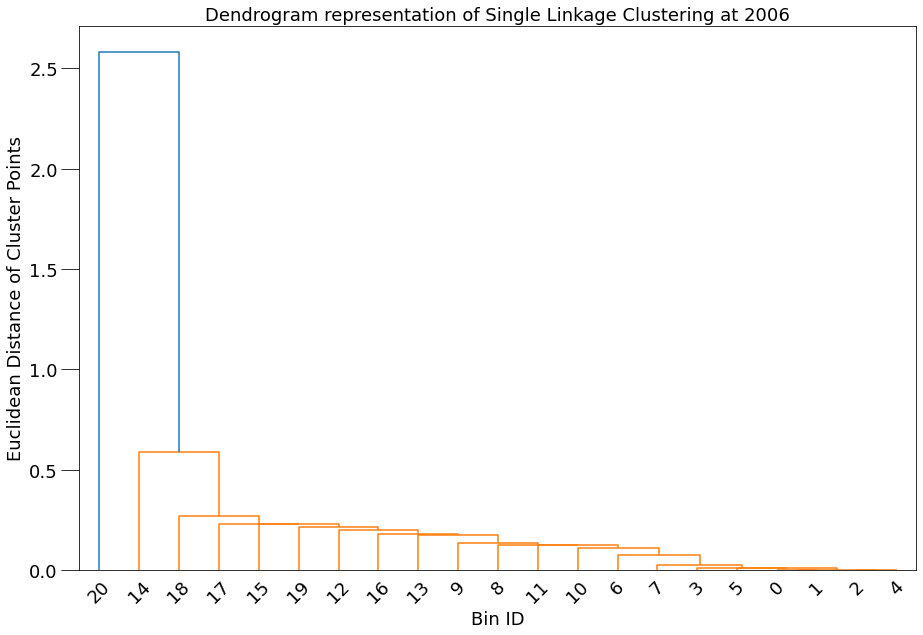

In [16]:
fig = plt.figure(figsize = (15, 10))
    
ax = fig.gca()
ax.tick_params(axis='y', size=18, labelsize = 18)
ax.set_xlabel('Bin ID', fontsize = 18)
ax.set_ylabel('Euclidean Distance of Cluster Points', fontsize = 18)
ax.set_ylim(bottom = 0, top =  3.5)
ax.set_title ('Dendrogram representation of Single Linkage Clustering at 2006', fontsize = 18)
dendrogram(source_dendro[3], leaf_font_size = 18, count_sort = 'ascending')

plt.show()

# Plot dendrogram - Subfigures, final

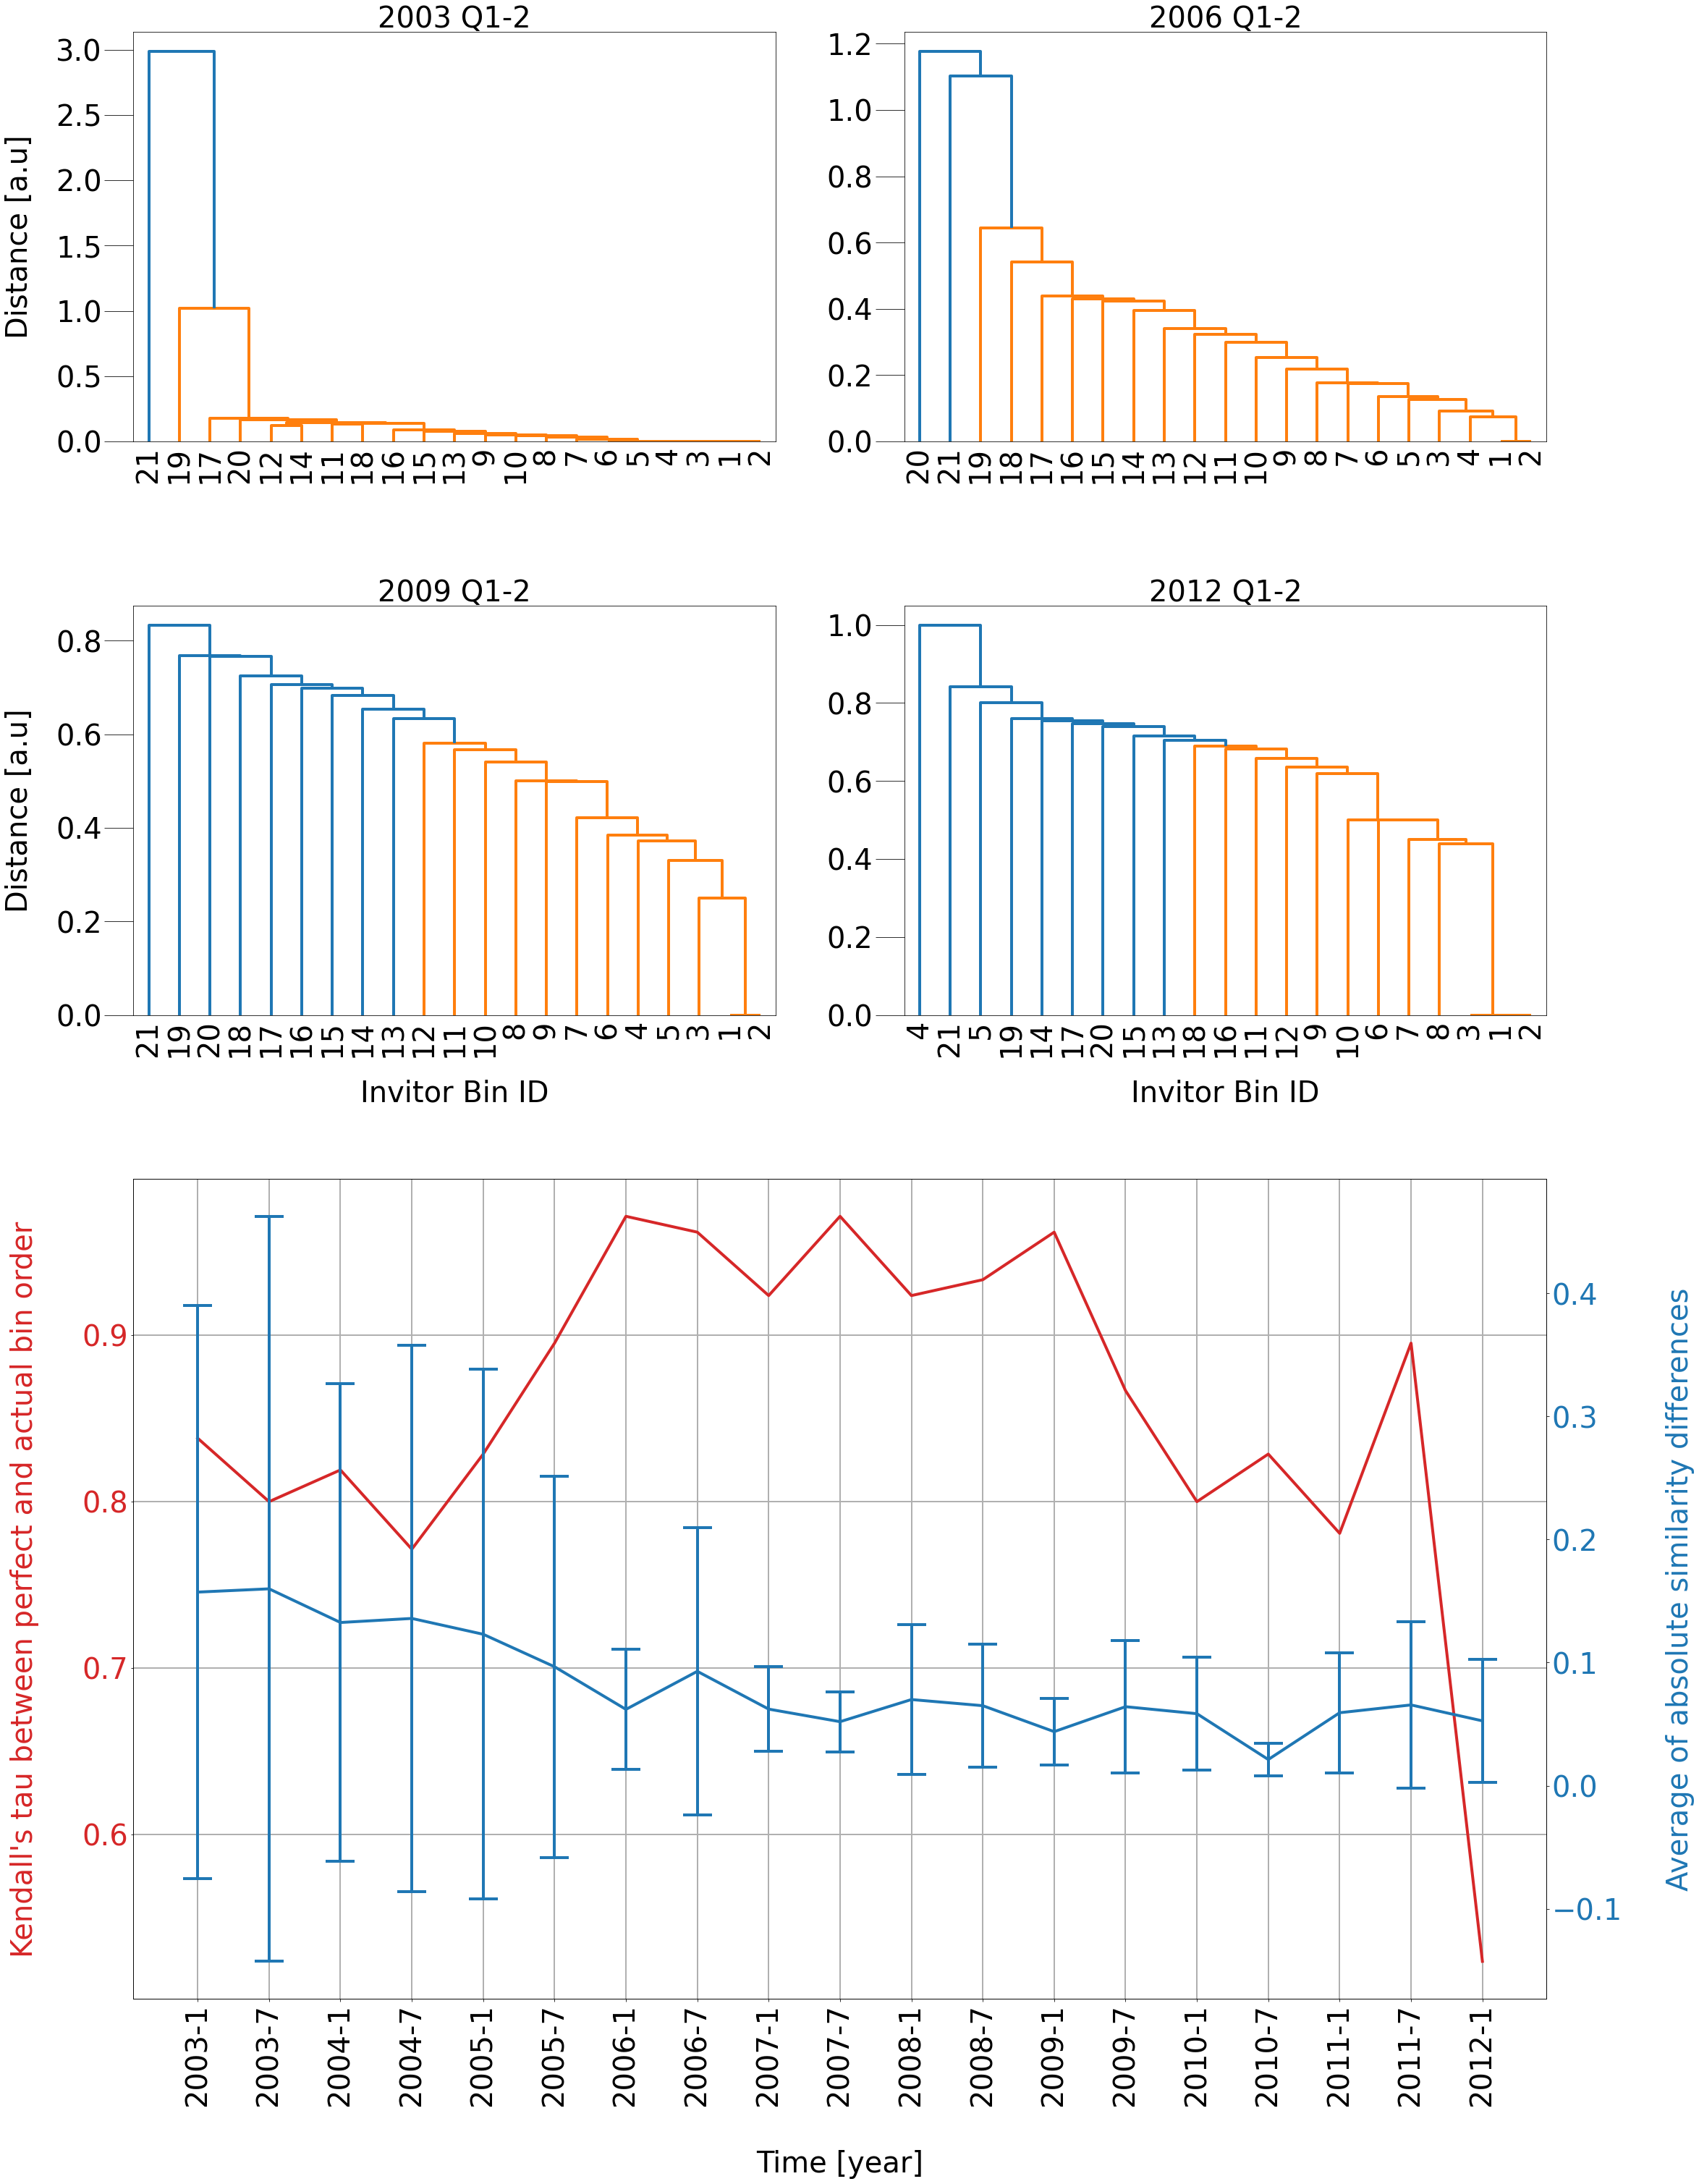

In [17]:
df_clustDist = pd.DataFrame(clusterDist['source']).transpose()
df_hierarchyDiff = pd.DataFrame(hierarchyDiff['source']).transpose()

xticks = []
for s in df_clustDist.index:
    xticks.append('-'.join(s.split('_')[1].split('-')[0:-1]))

fig3 = plt.figure(figsize = (35, 50))
gs = fig3.add_gridspec(3, 2, height_ratios = (0.25, 0.25, 0.5))
gs.update(hspace=0.3,wspace=0.2)

fs = 40

ax1 = fig3.add_subplot(gs[0, 0])
matplotlib.rcParams['lines.linewidth'] = 4
ax1.tick_params(axis='y', size=fs, labelsize = fs)
#ax3.set_xlabel('Bin ID', fontsize = fs)
ax1.set_ylabel('Distance [a.u]', fontsize = fs, labelpad = 30)
ax1.set_title ('2003 Q1-2', fontsize = fs)
dendrogram(source_dendro[0], ax = ax1, leaf_font_size = fs, leaf_rotation = 90, count_sort = 'ascending', labels = range(1, 22))

ax2 = fig3.add_subplot(gs[0, 1])
ax2.tick_params(axis='y', size=fs, labelsize = fs)
#ax4.set_xlabel('Bin ID', fontsize = fs)
#ax4.set_ylabel('Distance [a.u]', fontsize = fs)
ax2.set_title ('2006 Q1-2', fontsize = fs)
dendrogram(source_dendro[6], ax = ax2, leaf_font_size = fs, leaf_rotation = 90, count_sort = 'ascending', labels = range(1, 22))

ax3 = fig3.add_subplot(gs[1, 0])
ax3.tick_params(axis='y', size=fs, labelsize = fs)
ax3.set_xlabel('Invitor Bin ID', fontsize = fs, labelpad = 30)
ax3.set_ylabel('Distance [a.u]', fontsize = fs, labelpad = 30)
ax3.set_title ('2009 Q1-2', fontsize = fs)
dendrogram(source_dendro[12], ax = ax3, leaf_font_size = fs, leaf_rotation = 90, count_sort = 'ascending', labels = range(1, 22))

ax4 = fig3.add_subplot(gs[1, 1])
ax4.tick_params(axis='y', size=fs, labelsize = fs)
ax4.set_xlabel('Invitor Bin ID', fontsize = fs, labelpad = 30)
#ax6.set_ylabel('Distance [a.u]', fontsize = fs)
ax4.set_title ('2012 Q1-2', fontsize = fs)
dendrogram(source_dendro[18], ax = ax4, leaf_font_size = fs, leaf_rotation = 90, count_sort = 'ascending', labels = range(1, 22))

ax5 = fig3.add_subplot(gs[2, :])
ax6 = ax5.twinx()


color = 'tab:red'
ax5.set_xlabel('Time [year]', fontsize = fs, labelpad = 60)
ax5.set_ylabel('Kendall\'s tau between perfect and actual bin order', color=color, fontsize = fs, labelpad = 60)
ax5.errorbar(np.arange(0, len(df_hierarchyDiff['avg']), 1),
             df_hierarchyDiff['avg'], 
             color = color,
             capsize = 20,
             capthick = 4,
             linewidth = 4)
ax5.tick_params(axis='y', labelcolor=color, labelsize = fs)
ax5.tick_params(axis='x', labelsize = fs)
ax5.set_xticks(np.arange(0, len(df_hierarchyDiff['avg']), 1))
ax5.set_xticklabels(xticks, rotation = 'vertical')

color = 'tab:blue'
ax6.set_ylabel('Average of absolute similarity differences', color=color, fontsize = fs, labelpad = 60) 
ax6.errorbar(np.arange(0, len(df_hierarchyDiff['avg']), 1),
             df_clustDist['avg'], 
             yerr=df_clustDist['std']/2, 
             color = color,
             capsize = 20,
             capthick = 4,
             linewidth = 4)
ax5.grid(linewidth = 2)
ax6.tick_params(axis='y', labelcolor=color, labelsize = fs)
plt.savefig('./plots_out/dendrograms.pdf')
plt.rcParams['figure.figsize'] = 12,8
matplotlib.rcParams['lines.linewidth'] = 2

# Integrated measures helper functions

In [18]:
# Function for creating the elements of integrated measure. year and month parameters starting from 1 and they are inclusive
def getInvitationNumbers(df_filtered, userColName, invitorColName, yearStart, yearEnd, monthStart, monthEnd, dm):
    e_s_bin = collections.defaultdict(dict)
    e_t_bin = collections.defaultdict(dict)
    i_s_bin = collections.defaultdict(dict)
    
    for year in range(yearStart, yearEnd+1):
        for month in range(monthStart, monthEnd+1, dm):
            # Create a df in the given time range. Using RegYear would be easier, but this allows evaluation on
            # smaller timescale
            if (month+dm) > 12:
                df = df_filtered[(df_filtered['RegistrationDate'] < datetime.datetime(year+1,(month+dm)%12 ,1)) & 
                     (df_filtered['RegistrationDate'] > datetime.datetime(year,month,1))]
            else:
                df = df_filtered[(df_filtered['RegistrationDate'] < datetime.datetime(year,month+dm,1)) & 
                     (df_filtered['RegistrationDate'] > datetime.datetime(year,month,1))] 

            for binId in sorted(df_filtered[userColName].unique()):
                # Outgoing
                e_s_bin[str(binId)]["{}-{}".format(year, month)] = ((df[invitorColName] == binId) & 
                                                                     (df[userColName] != df[invitorColName])).sum()

                # Incoming (from outside) invitations to the bin
                e_t_bin[str(binId)]["{}-{}".format(year, month)] = ((df[userColName] == binId) & 
                                                                     (df[invitorColName] != df[userColName])).sum()
                # Internal invitations in a bin
                i_s_bin[str(binId)]["{}-{}".format(year, month)] = ((df[userColName] ==binId) & 
                                                                     (df[invitorColName] == binId)).sum()
                
    return e_s_bin, e_t_bin, i_s_bin

def calcMeasure(e_s_bin, e_t_bin, i_s_bin):
    target_measure = {}
    source_measure = {}
    for key in e_s_bin.keys():
        target_measure[key] = np.divide(np.fromiter(e_t_bin[key].values(), dtype = int)-\
                                                    np.fromiter(i_s_bin[key].values(), dtype = int),
                                        np.fromiter(e_t_bin[key].values(), dtype = int)+\
                                                    np.fromiter(i_s_bin[key].values(), dtype = int))
        
        source_measure[key] = np.divide(np.fromiter(e_s_bin[key].values(), dtype = int)-\
                                                    np.fromiter(i_s_bin[key].values(), dtype = int),
                                        np.fromiter(e_s_bin[key].values(), dtype = int)+\
                                                    np.fromiter(i_s_bin[key].values(), dtype = int))
        
        target_df = pd.DataFrame.from_dict(target_measure)
        target_df['timestamp'] = e_t_bin[list(e_t_bin.keys())[0]].keys()
        target_df = target_df.set_index('timestamp')

        source_df = pd.DataFrame.from_dict(source_measure)
        source_df['timestamp'] = e_s_bin[list(e_s_bin.keys())[0]].keys()
        source_df = source_df.set_index('timestamp')
        
    return target_df, source_df

def getIntegratedMeasures(df_filtered, yearStart, yearEnd, monthStart, monthEnd, dm = 3, binned = False, nthlargest = 50):
    if not binned:
        df_cut = df_filtered[(df_filtered['PopLog'] > sorted(df_filtered['PopLog'].unique(), 
                                                             reverse = True)[nthlargest]) & \
                        (df_filtered['InvitorPopLog'] > sorted(df_filtered['PopLog'].unique(), 
                                                               reverse = True)[nthlargest])]
        e_s_bin, e_t_bin, i_s_bin = getInvitationNumbers(df_cut, 
                                                          'PopLog', 
                                                          'InvitorPopLog',
                                                           yearStart, yearEnd, monthStart, monthEnd, dm)
        
        target_df, source_df = calcMeasure(e_s_bin, e_t_bin, i_s_bin)
        

    else:
        e_s_bin, e_t_bin, i_s_bin = getInvitationNumbers(df_filtered, 
                                                          'Bin', 
                                                          'InvitorBin',
                                                           yearStart, yearEnd, monthStart, monthEnd, dm)
        
        target_df, source_df = calcMeasure(e_s_bin, e_t_bin, i_s_bin)
        
    return target_df, source_df

# Calculate integrated measures

In [19]:
target_df, source_df = getIntegratedMeasures(df_filtered, 2003, 2012, 1, 12, 6, True)

<ipython-input-18-7905b1d431ac>:36: RuntimeWarning: invalid value encountered in true_divide
  target_measure[key] = np.divide(np.fromiter(e_t_bin[key].values(), dtype = int)-\
<ipython-input-18-7905b1d431ac>:41: RuntimeWarning: invalid value encountered in true_divide
  source_measure[key] = np.divide(np.fromiter(e_s_bin[key].values(), dtype = int)-\


In [20]:
target_df.drop(target_df.tail(1).index, inplace=True)
source_df.drop(source_df.tail(1).index, inplace=True)

# Plot Integrated Measures final

<ipython-input-21-32e19f13f636>:6: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("RdBu_r"))
  current_cmap.set_bad(color='Gray')


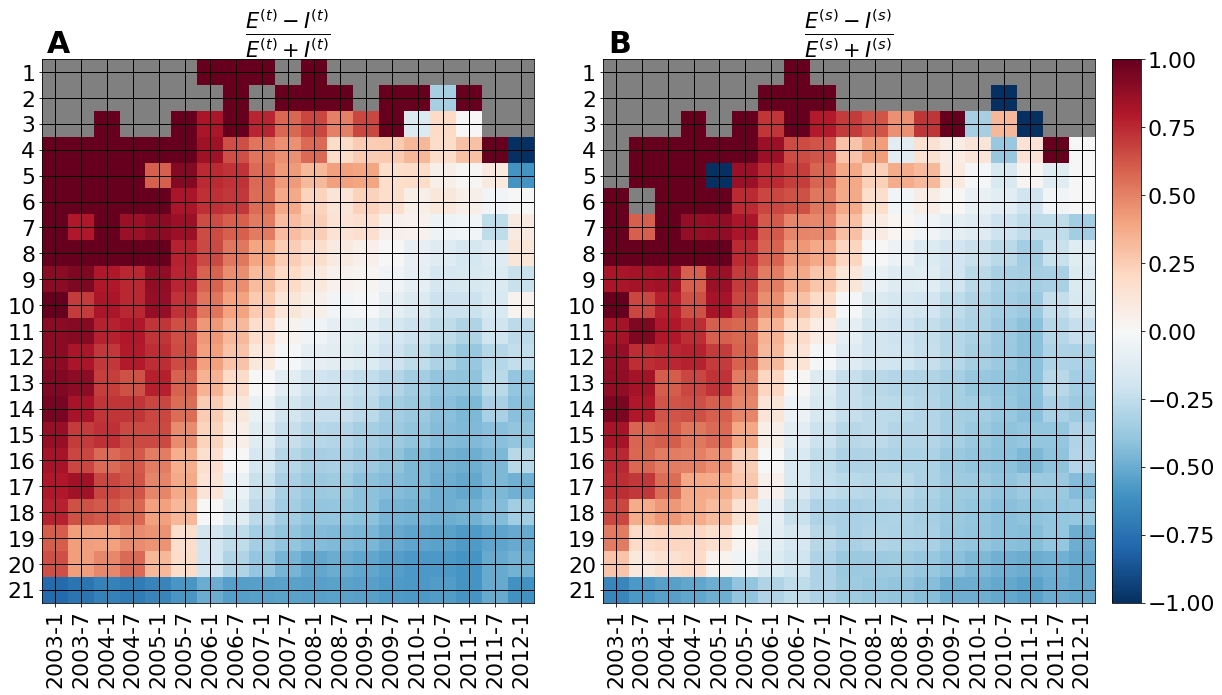

In [21]:
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (20, 60))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
fig.subplots_adjust(wspace=0.01)

current_cmap = matplotlib.cm.get_cmap('RdBu_r')
current_cmap.set_bad(color='Gray')

plot1 = ax1.imshow(np.array(target_df.values, dtype = float).T, cmap = current_cmap, vmin = -1, vmax = 1)
ax1.set_title(r"$\frac{E^{(t)}-I^{(t)}}{E^{(t)}+I^{(t)}}$", fontsize = 30)
ax1.set_xticks(range(0, len(list(target_df.index))))
ax1.set_xticklabels(list(target_df.index), fontsize = 22, rotation = 'vertical')
ax1.set_yticks(range(0, len(target_df.columns)))
ax1.set_yticklabels(target_df.columns, fontsize = 22)
ax1.grid(color = 'black', linewidth = 1)
fig.text(0.15, 0.89, 'A', fontweight = 'bold', fontsize = 30)

ax2.imshow(np.array(source_df.values, dtype = float).T, cmap = current_cmap)
ax2.set_title(r"$\frac{E^{(s)}-I^{(s)}}{E^{(s)}+I^{(s)}}$", fontsize = 30)
ax2.set_xticks(range(0, len(list(source_df.index))))
ax2.set_xticklabels(list(source_df.index), fontsize = 22, rotation = 'vertical')
ax2.set_yticks(range(0, len(source_df.columns)))
ax2.set_yticklabels(source_df.columns, fontsize = 22)
ax2.grid(color = 'black', linewidth = 1)
fig.text(0.54, 0.89, 'B', fontweight = 'bold', fontsize = 30)
cbar_ax = fig.add_axes([0.89, 0.125, 0.02, 0.755])
cbar = fig.colorbar(plot1, cax=cbar_ax)
cbar.ax.tick_params(labelsize = 22)
#plt.savefig('./integrated_target_source.png')

#y = df_filtered[df_filtered['RegByMonth'] >= '2003-1'].groupby('RegByQ')['Id'].count().values/100000
#ax3.plot(y, linewidth = 3)
#ax3.set_title('Newly registered users', fontsize = 50)
#ax3.set_aspect(10)
#ax3.set_xlim(ax2.get_xlim())
#ax3.set_xticks(range(0, len(list(target_df.index)), 2))
#ax3.set_xticklabels(list(target_df.index)[::2], fontsize = 50, rotation = 'vertical')
#ax3.set_yticks(np.arange(0, 250000/100000, 30000/100000))
#ax3.set_yticklabels(np.round(np.arange(0, 250000/100000, 30000/100000), 2), fontsize = 50)
#ax3.set_ylabel('New Users in 100000s', fontsize = 50)
#ax3.grid()
#fig.text(0.13, 0.343, 'C', fontweight = 'bold', fontsize = 80)
plt.savefig('./plots_out/integrated_v2.pdf')

# Registration date related stuff

In [22]:
df_filtered['RegYear'] = pd.to_numeric(df_filtered['RegYear'])

In [23]:
df_filtered['Age'] = df_filtered['RegYear'].values-df_filtered['BirthYear'].values
# be older than 7 years at the age of registration, an younger than 75
df_agedist = df_filtered[((df_filtered['Age'] > 7) & (df_filtered['Age'] <= 75))][['Id', 'RegByMonth', 'Age']]

agebin_edges = [[8, 18], [19, 29], [30, 40], [41, 51], [52, 62], [63, 73]] 

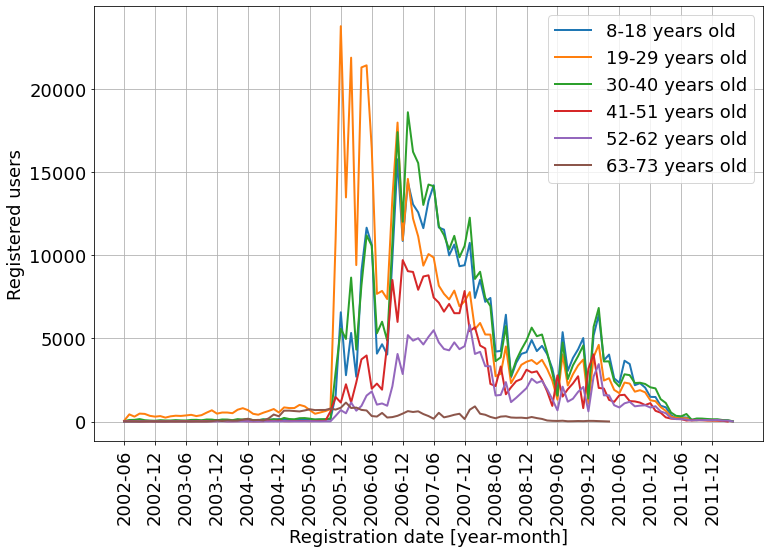

In [24]:
plt.figure(figsize = (12, 8))
for i in range(0, len(agebin_edges)):
    y = df_agedist[(df_agedist['Age'] >= agebin_edges[i][0]) & 
           (df_agedist['Age'] <= agebin_edges[i][1])].groupby('RegByMonth').count()['Id'].values
    plt.plot(y, label = '{}-{} years old'.format(agebin_edges[i][0], agebin_edges[i][1]))

y = df_filtered['RegByMonth'].unique().astype(str)
plt.xticks(range(0, len(y), 6), 
           np.sort(df_filtered['RegByMonth'].unique().astype(str))[range(0, len(y), 6)],
           rotation = 'vertical',
           fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('Registration date [year-month]', fontsize = 18)
plt.ylabel('Registered users', fontsize = 18)
plt.grid()
plt.legend(fontsize = 18)
plt.show()

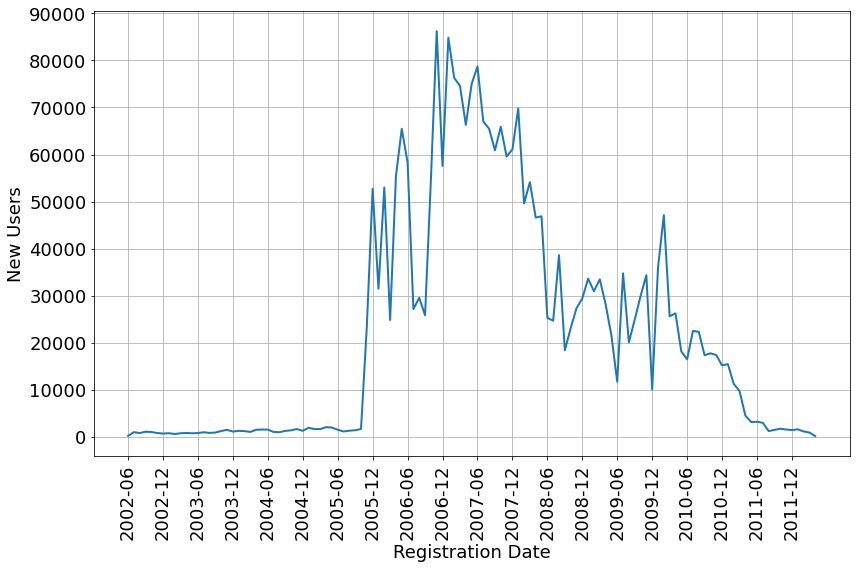

In [25]:
#Invitations sent at a given month
plt.figure(figsize = (12, 8))
y = df_filtered.groupby('RegByMonth')['Id'].count().values
plt.plot(y, linewidth = '2')
plt.xlabel('Registration Date', fontsize = 18)
plt.xticks(range(0, len(y), 6), 
           np.sort(df_filtered['RegByMonth'].unique().astype(str))[range(0, len(y), 6)],
           rotation = 'vertical',
           fontsize = 18)
plt.ylabel('New Users', fontsize = 18)
plt.yticks(range(0, 90001, 10000), range(0, 90001, 10000), fontsize = 18)
plt.grid()
plt.tight_layout()
plt.savefig('./plots_out/invfreq.pdf')

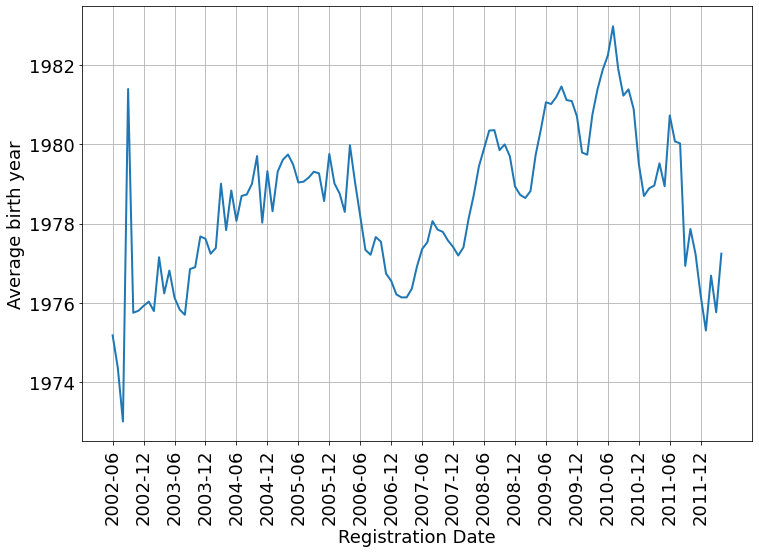

In [26]:
# Average birth year in time. Interesting drop at 2007 and 2012. 
# The periodicity after 2007 is also interesting
# However the birthyear peak is at 2011, I wouldn't say that significantly older people got invited at later periods
plt.figure(figsize = (12, 8))
y = df_filtered.groupby('RegByMonth')['BirthYear'].mean().values
plt.plot(y)
plt.xlabel('Registration Date', fontsize = 18)
plt.ylabel('Average birth year', fontsize = 18)
plt.xticks(range(0, len(y), 6), 
           np.sort(df_filtered['RegByMonth'].unique().astype(str))[range(0, len(y), 6)],
           rotation = 'vertical',
           fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()

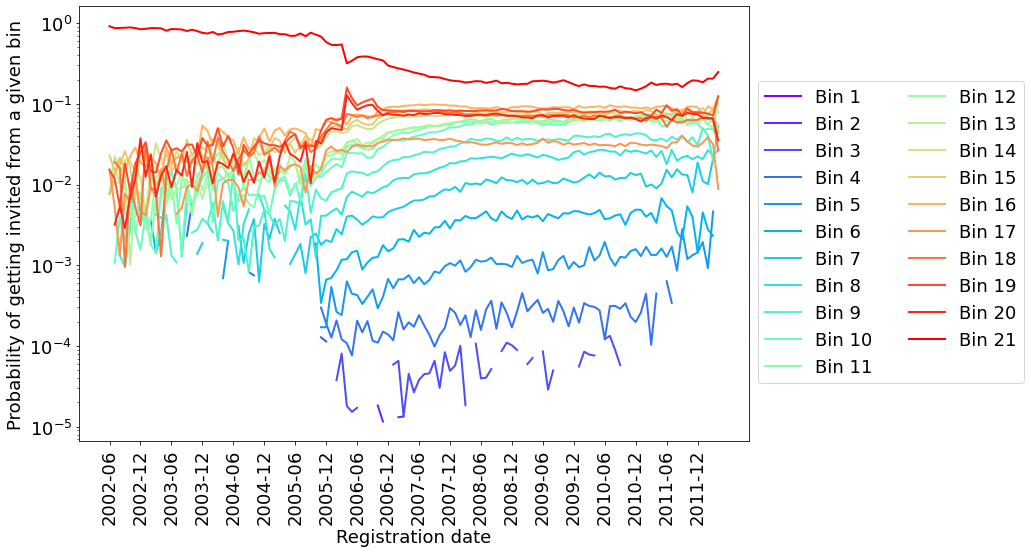

In [27]:
# This shows the probability of getting invited from a given bin. 
# This measure is biased by the population of the bin.
inv_prob_df = df_filtered.groupby(['RegByMonth', 'InvitorBin']).count().unstack(level = 1)['Id'].divide(
    df_filtered.groupby(['RegByMonth', 'InvitorBin']).count().unstack(level = 1)['Id'].sum(axis = 1), axis = 'rows')

plt.figure(figsize = (12, 8))

color=cm.rainbow(np.linspace(0,1,inv_prob_df.values.shape[-1]))
for i, c in zip(range(0, inv_prob_df.values.shape[-1]), color):
    plt.plot(inv_prob_df.values[:,i], label = 'Bin {}'.format(i+1), color = c)
    
plt.legend(fontsize = 18, ncol = 2, bbox_to_anchor=(1.,0.85), loc="upper left")
plt.yscale('log')
plt.ylabel('Probability of getting invited from a given bin', fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlabel('Registration date', fontsize = 18)
plt.xticks(range(0, len(y), 6), 
           np.sort(df_filtered['RegByMonth'].unique().astype(str))[range(0, len(y), 6)],
           rotation = 'vertical',
           fontsize = 18)
plt.show()

In [28]:
df_filtered['PopDiff'] = np.power(10, df_filtered['InvitorPopLog'].values)-np.power(10,df_filtered['PopLog'].values)
df_filtered['PopLogDiff'] = df_filtered['InvitorPopLog']-df_filtered['PopLog']

y = df_filtered[df_filtered['InvitorCityId'] != df_filtered['CityId']][['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).mean()['PopDiff']
y_err = df_filtered[df_filtered['InvitorCityId'] != df_filtered['CityId']][['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).std()['PopDiff']

<AxesSubplot:>

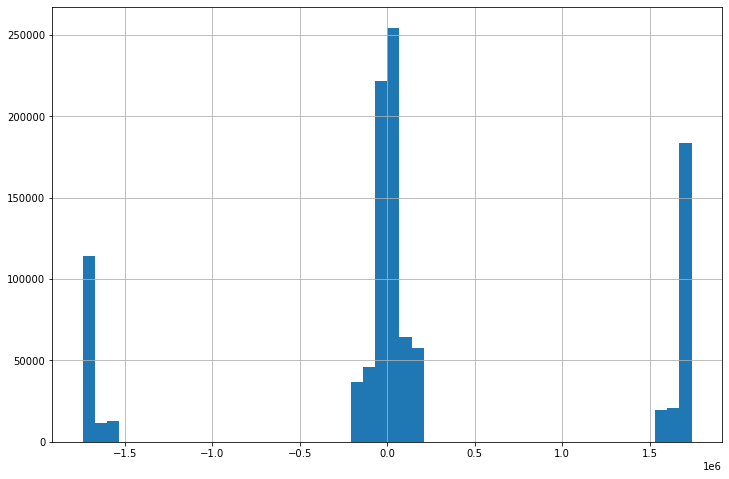

In [29]:
df_filtered[df_filtered['InvitorCityId'] != df_filtered['CityId']]['PopDiff'].hist(bins = 50)

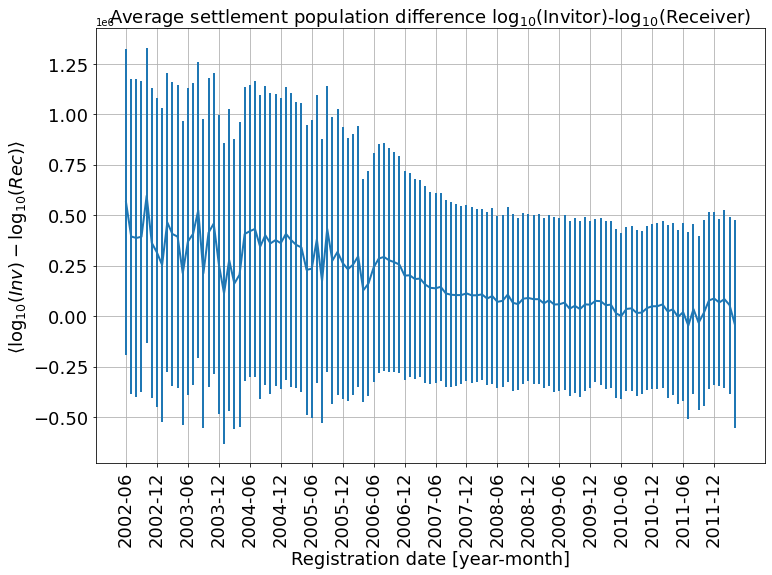

In [30]:
plt.figure(figsize = (12, 8))
plt.errorbar(y.index.astype(str), y.values, y_err.values/2)
plt.title(r'Average settlement population difference $\log_{10}$(Invitor)-$\log_{10}$(Receiver)', fontsize = 18)
plt.xlabel('Registration date [year-month]', fontsize = 18)
plt.ylabel(r'$\langle \log_{10}(Inv)-\log_{10}(Rec) \rangle$', fontsize = 18)
plt.xticks(range(0, len(y.index.astype(str)),6), y.index.astype(str)[0::6], 
           rotation = 'vertical', fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()
plt.show()

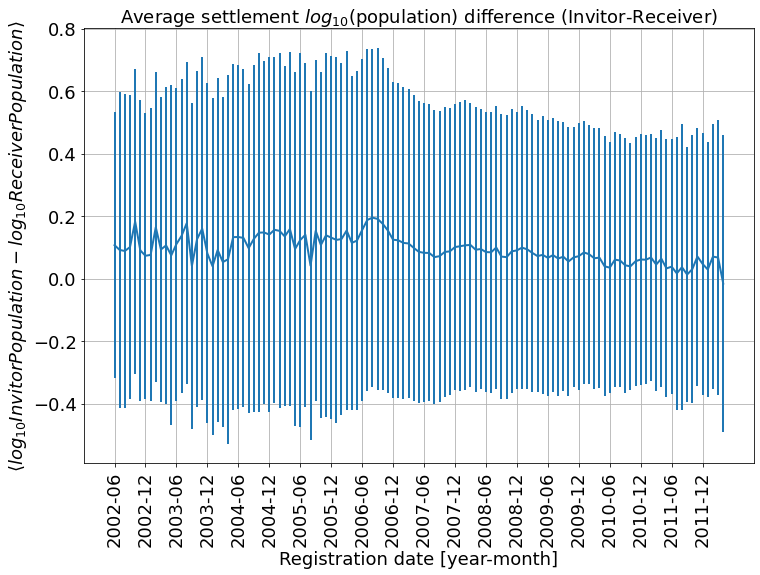

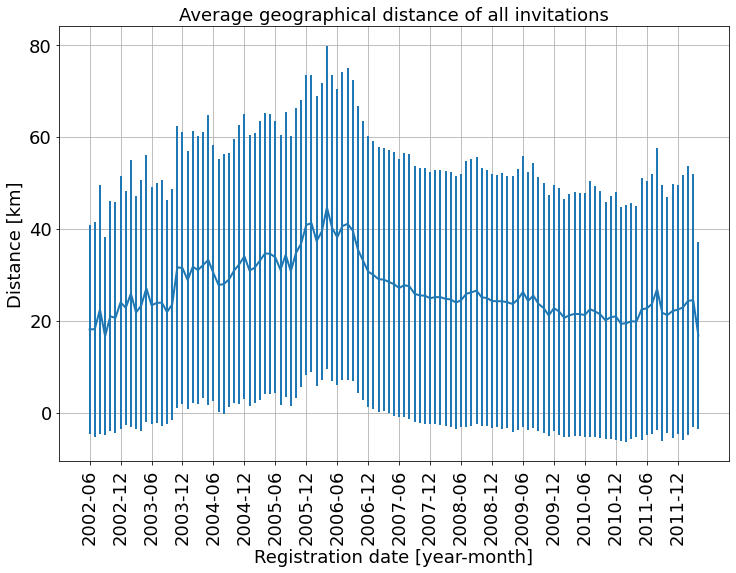

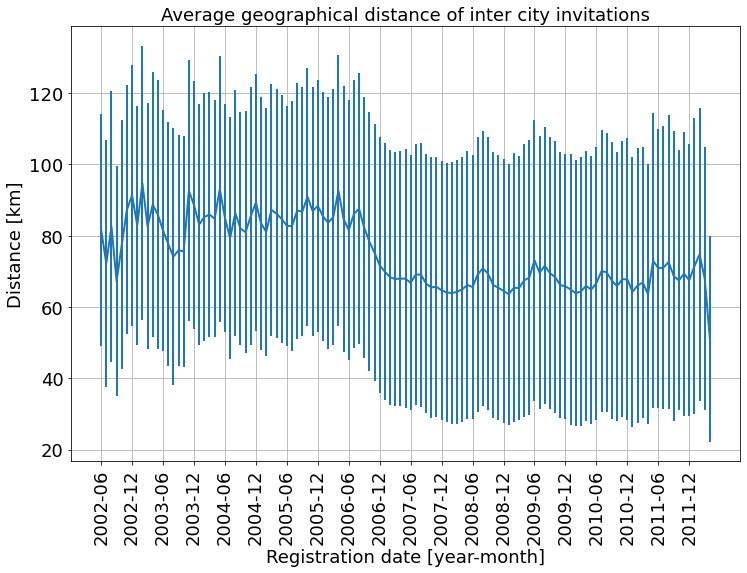

In [31]:
y = df_filtered[['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).mean()['PopLogDiff']
y_err = df_filtered[['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).std()['PopLogDiff']

plt.figure(figsize = (12, 8))
plt.errorbar(y.index.astype(str), y.values, y_err.values/2)
plt.title(r'Average settlement $log_{10}$(population) difference (Invitor-Receiver)', fontsize = 18)
plt.xlabel('Registration date [year-month]', fontsize = 18)
plt.ylabel(r'$\langle log_{10}InvitorPopulation-log_{10}ReceiverPopulation \rangle$', fontsize = 18)
plt.xticks(range(0, len(y.index.astype(str)),6), y.index.astype(str)[0::6], 
           rotation = 'vertical', fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()
plt.show()

y = df_filtered[['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).mean()['Distance']
y_err = df_filtered[['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).std()['Distance']

plt.figure(figsize = (12, 8))
plt.errorbar(y.index.astype(str), y.values, y_err.values/2)
plt.title(r'Average geographical distance of all invitations', fontsize = 18)
plt.xlabel('Registration date [year-month]', fontsize = 18)
plt.ylabel('Distance [km]', fontsize = 18)
plt.xticks(range(0, len(y.index.astype(str)),6), y.index.astype(str)[0::6], 
           rotation = 'vertical', fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()
plt.show()

y = df_filtered[df_filtered['CityId'] != df_filtered['InvitorCityId']][['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).mean()['Distance']
y_err = df_filtered[df_filtered['CityId'] != df_filtered['InvitorCityId']][['RegByMonth', 'Distance', 'PopDiff', 'PopLogDiff']].groupby(['RegByMonth']).std()['Distance']

plt.figure(figsize = (12, 8))
plt.errorbar(y.index.astype(str), y.values, y_err.values/2)
plt.title('Average geographical distance of inter city invitations', fontsize = 18)
plt.xlabel('Registration date [year-month]', fontsize = 18)
plt.ylabel(r'Distance [km]', fontsize = 18)
plt.xticks(range(0, len(y.index.astype(str)),6), y.index.astype(str)[0::6], 
           rotation = 'vertical', fontsize = 18)
plt.yticks(fontsize = 18)
plt.grid()
plt.show()

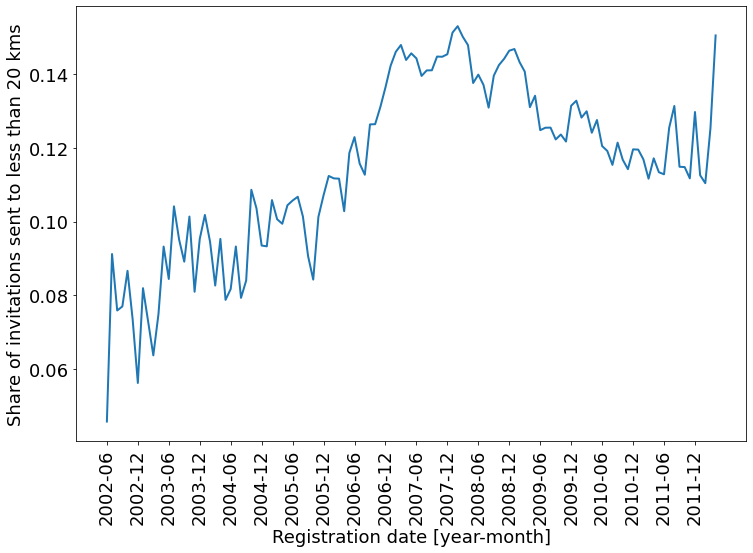

In [32]:
plt.figure(figsize = (12, 8))
y = (df_filtered[(df_filtered['Distance'] <= 20) & (df_filtered['CityId'] != df_filtered['InvitorCityId'])][['RegByMonth', 'Distance']].
                         groupby('RegByMonth').count()/df_filtered[['RegByMonth', 'Distance']].
                                                             groupby('RegByMonth').count())
plt.plot(y.index.astype(str), y['Distance'], lw = 2)
plt.xlabel('Registration date [year-month]', fontsize = 18)
plt.ylabel('Share of invitations sent to less than 20 kms', fontsize = 18)
plt.xticks(range(0, len(y.index.astype(str)),6), y.index.astype(str)[0::6], 
           rotation = 'vertical', fontsize = 18)
plt.yticks(fontsize = 18)
plt.show()

# City-level network

Networkx's default maximal spanning tree finder algorithm won't work, since there won't be a connected spanning tree, but a spanning forest instead. Edmonds' algorithm gives back the spanning forest, and it will have a large number of unconnected components. Because of this the distance between some cities and Budapest can't be calculated. I have checked these components and I've noticed that almost all of the components are individual nodes without any edges. These can be dropped and only the giant component being kept. If the non-giant components are not negligible (there is no such case until 2007), the distance between the cities and the largest city of their component should be calculated instead to get the distance-city size distribution. 

In [33]:
import networkx as nx
from networkx.algorithms.shortest_paths.generic import shortest_path_length

# Export edgelist

In [34]:
# df_timeslice function debug

year_dict = {"start": 2006, "end": 2008}
month_dict = {"start": 1, "end": 12}
day_dict = {"start": 1, "end": 31}

df_timeslice = getTimeSlicedData(year_dict, 
                                 month_dict, 
                                 day_dict)

print(df_timeslice['RegistrationDate'].min())
print(df_timeslice['RegistrationDate'].max())

2006-01-01 00:00:00
2008-12-31 00:00:00


In [35]:
dm = 6

nodelist = cities[["CityId", "Latitude", "Longitude", "PopLog", "CityName"]]
edgelist_rootdir = './edgelists_periods'
nodelist.to_csv('{}/nodelist.csv'.format(edgelist_rootdir))

for year_start in range(2003, 2013):
    year_end = year_start
    for month in range(1, 13, dm):
        if (year_start == 2012) and (month >= 7):
            break
        endday = 31
        if ( (month + dm-1) == 2) and (((year % 4) == 0) and ((year % 100) == 0) and ((year % 400) == 0)):
            endday = 29
        elif ((month +dm -1) == 2):
            endday = 28
        elif (month + dm - 1) in [4, 6, 9, 11]:
            endday = 30
        
        year_dict = {"start": year_start, "end": year_end}
        month_dict = {"start": month, "end": month + dm-1}
        day_dict = {"start": 1, "end": endday}
        
        df_timeslice = getTimeSlicedData(year_dict, 
                                         month_dict, 
                                         day_dict)

        df_timeslice = df_timeslice[df_timeslice['CityId'] != df_timeslice['InvitorCityId']]
        edge_df = df_timeslice[["Id", 
                                 "CityId", 
                                 "InvitorCityId"]].groupby(["CityId",
                                                            "InvitorCityId"], as_index=False).count().rename(columns = {"Id": "NumOutInvs"})
        edge_df = edge_df.merge(df_timeslice[["CityId", "InvitorCityId", "Distance"]]).drop_duplicates()

        edge_norm_aux_df = (edge_df.groupby('InvitorCityId').sum()
                                                             .reset_index()
                                                             .rename(columns = {'NumOutInvs': 'norm'})[['InvitorCityId','norm']])
        edge_df = edge_df.merge(edge_norm_aux_df)
        edge_df['InvitationProb'] = edge_df['NumOutInvs']/edge_df['norm']
        edge_df = (edge_df.merge(nodelist[['CityId', 'CityName']].rename(columns = {'CityId': 'InvitorCityId',
                                                                                    'CityName': 'InvitorCityName'})))

        (edge_df[['CityId', 'InvitorCityId', 'NumOutInvs', 'norm', 'InvitationProb']]
                     .to_csv('{}/edgelist_{}-{}-{}_{}-{}-{}.csv'
                     .format(edgelist_rootdir, year_dict['start'], month_dict['start'], day_dict['start'],
                                                 year_dict['end'], month_dict['end'], day_dict['end'])))

# Map Plots

In [36]:
from matplotlib import colors
from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [37]:
plt.rcParams['figure.figsize'] = 15,12
plt.rcParams['font.size'] = 25
matplotlib.rcParams['lines.linewidth'] = 1

varosok = gpd.GeoDataFrame(gpd.read_file('../iwiw_data/terkep/OSN_region.shp'), crs = 'epsg:23700')
varosok.head(3)
iwiw_codes = cities.set_index('CityName')['CityId'].to_dict()
varosok['iwiw_code'] = varosok['HELYES']\
    .str.normalize('NFKD')\
    .str.encode('ascii', errors='ignore')\
    .str.decode('utf-8').map(iwiw_codes)
#varosok.dropna(subset = ['iwiw_code'], inplace = True)

l = [0, 10000, 20000, 50000, 100000, 1e6, 2e6]
df_filtered['BinId_Akos'] = np.digitize(np.power(10, df_filtered['PopLog'].values), l)
df_filtered['InvitorBinId_Akos'] = np.digitize(np.power(10, df_filtered['InvitorPopLog'].values), l)
df_filtered['RankDiff_Akos'] = -(df_filtered['InvitorBinId_Akos']-df_filtered['BinId_Akos'])

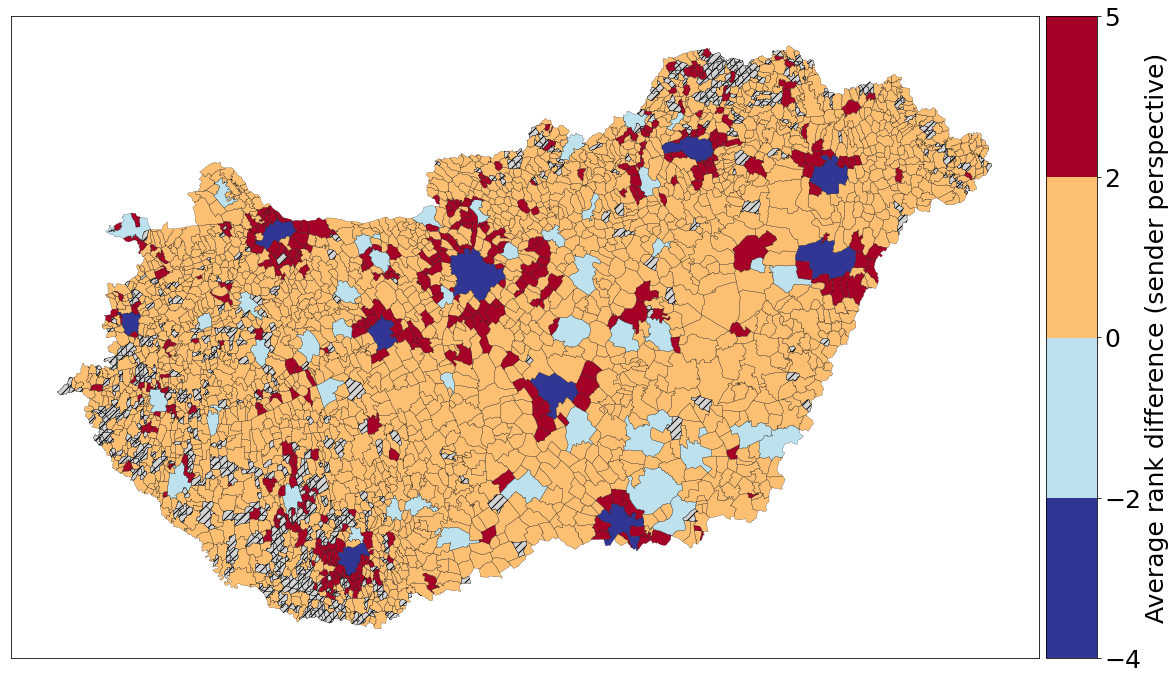

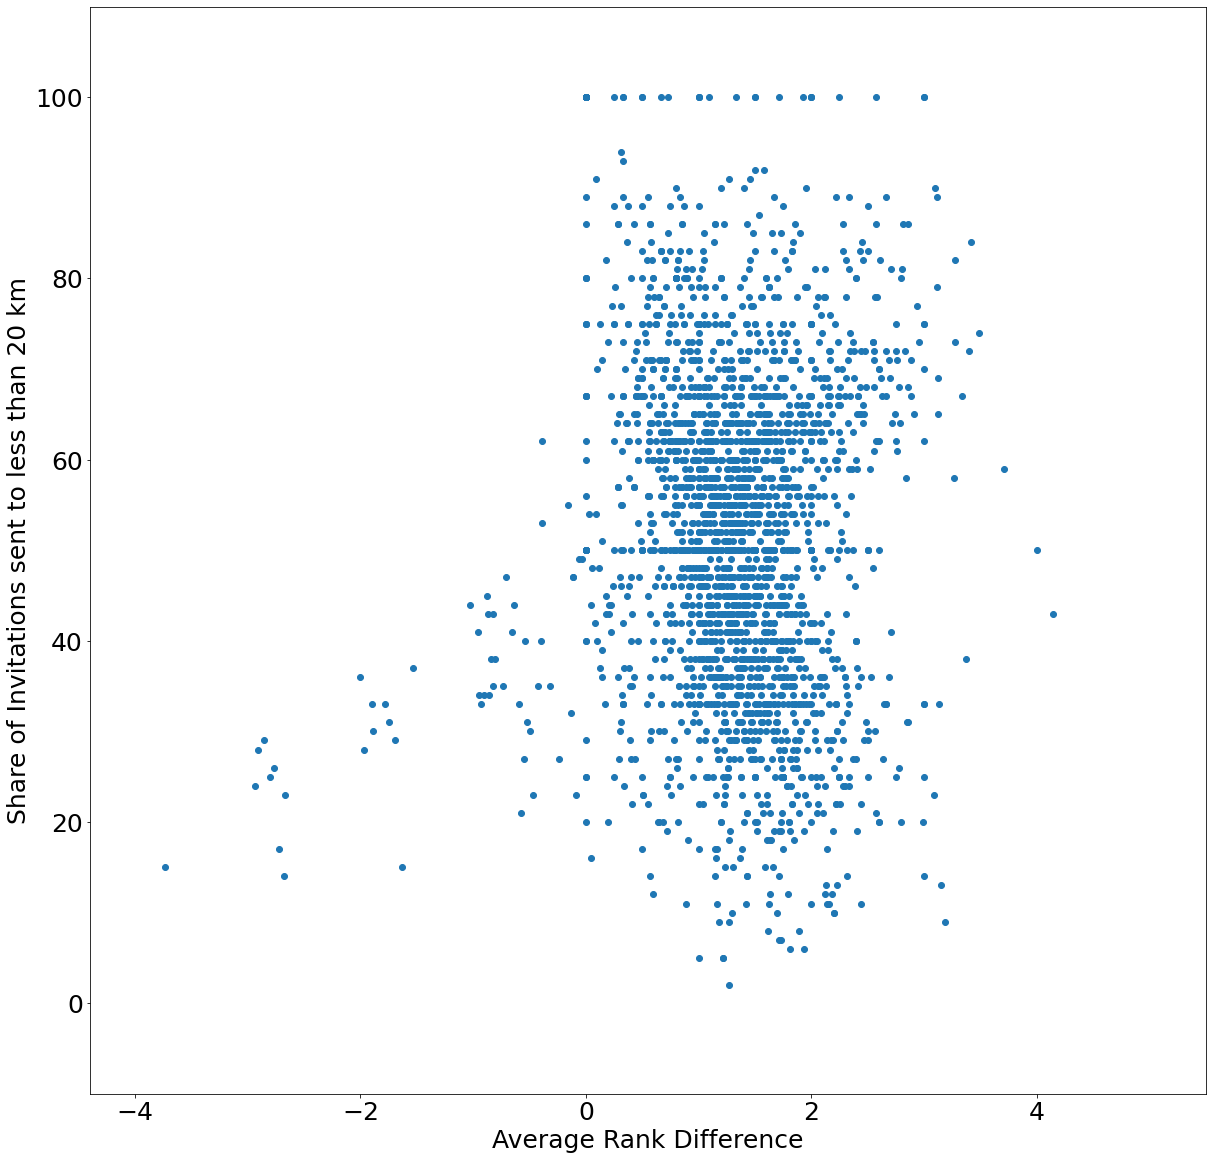

In [38]:
year_start = 2009
year_end = 2012

groupby_col = 'InvitorCityId'

varosok['PopLogDiff'] = varosok['iwiw_code'].map(df_filtered[(df_filtered['CityId'] != df_filtered['InvitorCityId'])&
                                                            (df_filtered['RegYear']  >= year_start) & 
                                                            (df_filtered['RegYear'] <= year_end)].groupby(groupby_col)['PopLogDiff'].mean().to_dict())
varosok['RankDiff'] = varosok['iwiw_code'].map(df_filtered[(df_filtered['CityId'] != df_filtered['InvitorCityId'])&
                                                            (df_filtered['RegYear']  >= year_start) & 
                                                            (df_filtered['RegYear'] <= year_end)].groupby(groupby_col)['RankDiff_Akos'].mean().to_dict())
                                               
varosok['Distance'] = varosok['iwiw_code'].map(df_filtered[(df_filtered['Distance'] <= 20) & 
                                                            (df_filtered['CityId'] != df_filtered['InvitorCityId'])&
                                                            (df_filtered['RegYear'] >= year_start) &
                                                            (df_filtered['RegYear'] <= year_end)].groupby(groupby_col).count()['Id'] /
                                               df_filtered[(df_filtered['CityId'] != df_filtered['InvitorCityId'])&
                                                            (df_filtered['RegYear'] >= year_start) &
                                                            (df_filtered['RegYear'] <= year_end)].groupby(groupby_col).count()['Id']).map(lambda x: round(x*100, 0))


plotType = 'RankDiff'

cmap = matplotlib.cm.get_cmap('RdYlBu_r')
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

l_bound = int(np.floor(varosok[plotType].min()))
u_bound = int(np.ceil(varosok[plotType].max()))

if (plotType =='RankDiff'):
    bounds = [l_bound, -2, 0, 2, u_bound]
    legend = "Average rank difference (sender perspective)"
elif (plotType == 'PopLogDiff'):
    bounds = list(np.linspace(l_bound, 0, np.abs(l_bound)+1))[0:-1] + list(np.linspace(0, u_bound, np.abs(l_bound)+1))
    legend = r"$Average \log_{10}\left(Pop\right) difference between receiver and sender between {} and {} (inclusive)".format(year_start, year_end)
elif (plotType == 'Distance'):
    cmap = matplotlib.cm.get_cmap('viridis')
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    if varosok[plotType].quantile(0.75) == 0:
        u_bound = varosok[plotType].max()
    else:
        u_bound = varosok[plotType].quantile(0.75)
    #bounds = np.linspace(0, u_bound, 10)
    bounds = [0, 20, 40, 60, 100]
    legend = "Percentage of invitations sent to less than 20 km"




norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax = varosok.plot(column=plotType,
                   figsize = (20, 10),
                   cmap=cmap,
                   norm = norm,
                   #legend=True,
                   #legend_kwds = {'label': legend,
                   #              'orientation': "horizontal"},
                   missing_kwds = {'color': 'lightgrey',
                                   'hatch': '///',
                                   'edgecolor': 'black',
                                   'linewidth': 0.2})


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax, cax = cax)
cbar.set_label(legend)


varosok.boundary.plot(ax = ax, 
                      linewidth = 0.2,
                      edgecolor = 'black')
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
#ax.set_title(legend)
plt.tight_layout()
plt.savefig('./plots_out/distance_map_2009_2012_AkosBin.pdf')

plt.figure(figsize = (20, 20))
plt.scatter(varosok['RankDiff'], varosok['Distance'])
plt.xlabel('Average Rank Difference')
plt.ylabel('Share of Invitations sent to less than 20 km')
plt.xlim(-4.4, 5.5)
plt.ylim(-10, 110)
plt.show()

# Put Dijkstra paths on the upper map

In [39]:
# ellista es csucspozicio fix az osszes szeletre
edgelist_rootdir = './edgelists_periods/'
nlist = pd.read_csv('{}/nodelist.csv'.format(edgelist_rootdir),index_col=0)
pos = nlist.set_index('CityId').apply(lambda row: [row['Longitude'],row['Latitude']],axis=1).to_dict()

T_s = []
shortest = []
for f in os.listdir(edgelist_rootdir):
    if 'edgelist' in f:
        # ev a fajlnevbol
        print(f)
        year = f.split('_')[1].split('-')[0]
        elist  = pd.read_csv(edgelist_rootdir+'/'+f,index_col=0)
        # creating $-\log(p)$ as future edge weights.
        elist['weight'] = elist['InvitationProb'].map(np.log)*(-1)

        # sulyozott graf
        G = nx.DiGraph()
        # dropping cities who didn't sent at least 20 invitations
        G.add_weighted_edges_from(elist[elist['norm']>=20][['InvitorCityId','CityId','weight']].values,weight='weight')

        # legrovidebb eleresi utak Budapestrol
        tree_l = nx.shortest_paths.weighted.single_source_dijkstra_path_length(G,source=379)
        # pontos elek grafja
        elist['source_l'] = elist['InvitorCityId'].map(tree_l)
        elist['target_l'] = elist['CityId'].map(tree_l)
        elist['diff_l'] = elist['target_l'] - elist['source_l']
        tlist = elist[np.abs(elist['diff_l']-elist['weight'])<1e-5]
        shortest.append(tree_l)
        T = nx.Graph()
        T.add_weighted_edges_from(tlist[['CityId','InvitorCityId', 'weight']].values, weight='weight')
        
        T_s.append(T)
        
        # mennyire faszeru a pontos elek grafja (~hany olyan csucs van, ahova tobb regrovidebb utvonal is megy)
        budapest_component_nodes = [c for c in nx.connected_components(T) if 379 in c][0]
        budapest_component  = nx.subgraph(T,budapest_component_nodes)
        print(year,"mennyire fa",len(budapest_component.edges())-len(budapest_component.nodes()))
        
        # hany lepesben ertem el a telepulest Budapestrol
        nlist['steps_'+year] = nlist['CityId'].map(nx.shortest_paths.single_source_dijkstra_path_length(T,source=379,weight=None))

        # poltolas
        #fig,ax = plt.subplots(1,2,figsize=(30,8))
        #nx.draw_networkx_nodes(T,pos,node_size=1,ax=ax[0])
        #nx.draw_networkx_edges(T,pos,width=[0.1 if u==379 else 0.5 for u,v in T.edges()],ax=ax[0])
        #ax[1].hist(nlist['steps_'+year],bins=4,range=(0,4))
        #ax[1].set_xlim(0,3.5)
        #ax[1].set_ylim(0,2500)
        #fig.suptitle(year)
        # plt.savefig('./figs/' + year +'_hierarchy.png',density=600)
        #plt.show()

edgelist_2003-1-1_2003-6-30.csv
2003 mennyire fa 4
edgelist_2003-7-1_2003-12-31.csv
2003 mennyire fa 0
edgelist_2004-1-1_2004-6-30.csv
2004 mennyire fa 3
edgelist_2004-7-1_2004-12-31.csv
2004 mennyire fa 1
edgelist_2005-1-1_2005-6-30.csv
2005 mennyire fa 5
edgelist_2005-7-1_2005-12-31.csv
2005 mennyire fa 11
edgelist_2006-1-1_2006-6-30.csv
2006 mennyire fa 3
edgelist_2006-7-1_2006-12-31.csv
2006 mennyire fa 11
edgelist_2007-1-1_2007-6-30.csv
2007 mennyire fa 5
edgelist_2007-7-1_2007-12-31.csv
2007 mennyire fa 5
edgelist_2008-1-1_2008-6-30.csv
2008 mennyire fa 15
edgelist_2008-7-1_2008-12-31.csv
2008 mennyire fa 16
edgelist_2009-1-1_2009-6-30.csv
2009 mennyire fa 15
edgelist_2009-7-1_2009-12-31.csv
2009 mennyire fa 28
edgelist_2010-1-1_2010-6-30.csv
2010 mennyire fa 11
edgelist_2010-7-1_2010-12-31.csv
2010 mennyire fa 29
edgelist_2011-1-1_2011-6-30.csv
2011 mennyire fa 30
edgelist_2011-7-1_2011-12-31.csv
2011 mennyire fa 14
edgelist_2012-1-1_2012-6-30.csv
2012 mennyire fa 6


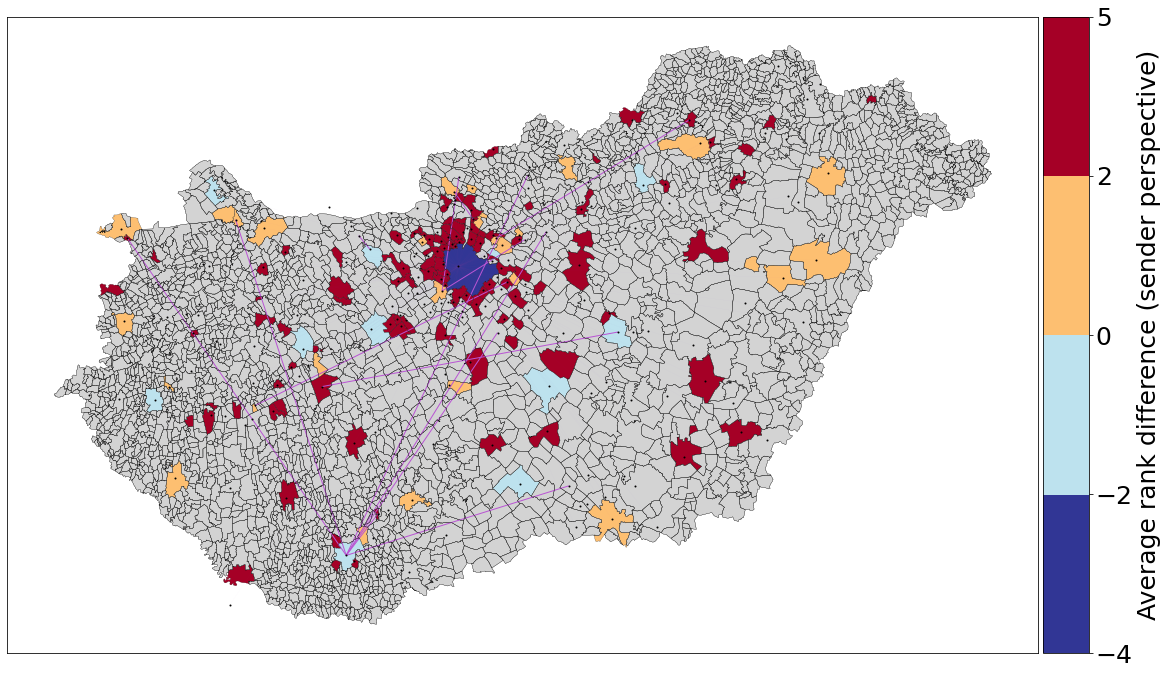

In [40]:
year_dict = {"start": 2003, "end": 2003}
month_dict = {"start": 1, "end": 6}
day_dict = {"start": 1, "end": 30}

df_timeslice = getTimeSlicedData(year_dict, 
                                 month_dict, 
                                 day_dict)
groupby_col = 'InvitorCityId'

varosok['PopLogDiff'] = (varosok['iwiw_code'].map(df_timeslice[(df_timeslice['CityId'] != df_timeslice['InvitorCityId'])]
                                                                                                     .groupby(groupby_col)['PopLogDiff'].mean().to_dict()))

varosok['RankDiff'] = (varosok['iwiw_code'].map(df_timeslice[(df_timeslice['CityId'] != df_timeslice['InvitorCityId'])]
                                                                                                       .groupby(groupby_col)['RankDiff_Akos'].mean().to_dict()))
                                               
varosok['Distance'] = varosok['iwiw_code'].map(df_timeslice[(df_timeslice['Distance'] <= 30) & 
                                                            (df_timeslice['CityId'] != df_timeslice['InvitorCityId'])].groupby(groupby_col).count()['Id'] /
                                               df_timeslice[(df_timeslice['CityId'] != df_timeslice['InvitorCityId'])].groupby(groupby_col).count()['Id']).map(lambda x: round(x*100, 0))


plotType = 'RankDiff'

cmap = matplotlib.cm.get_cmap('RdYlBu_r')
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

l_bound = int(np.floor(varosok[plotType].min()))
u_bound = int(np.ceil(varosok[plotType].max()))

if (plotType =='RankDiff'):
    bounds = [l_bound, -2, 0, 2, u_bound]
    legend = "Average rank difference (sender perspective)"
elif (plotType == 'PopLogDiff'):
    bounds = list(np.linspace(l_bound, 0, np.abs(l_bound)+1))[0:-1] + list(np.linspace(0, u_bound, np.abs(l_bound)+1))
    legend = r"$Average \log_{10}\left(Pop\right) difference between receiver and sender between {} and {} (inclusive)".format(year_start, year_end)
elif (plotType == 'Distance'):
    cmap = matplotlib.cm.get_cmap('viridis')
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
    if varosok[plotType].quantile(0.75) == 0:
        u_bound = varosok[plotType].max()
    else:
        u_bound = varosok[plotType].quantile(0.75)
    #bounds = np.linspace(0, u_bound, 10)
    bounds = [0, 20, 40, 60, 100]
    legend = "Percentage of invitations sent to less than 30 km"




norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


ax = varosok.to_crs('epsg:4326').plot(column=plotType,
                                       figsize = (20, 10),
                                       cmap=cmap,
                                       norm = norm,
                                       missing_kwds = {'color': 'lightgrey',
                                                       'edgecolor': 'black',
                                                       'linewidth': 0.2})


varosok.to_crs('epsg:4326').boundary.plot(ax = ax, 
                                          linewidth = 0.2,
                                          edgecolor = 'black')


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=-3.3)
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax, cax = cax)
cbar.set_label(legend)


nx_id = 0

nx.draw_networkx_nodes(T_s[nx_id], pos, 
                                   node_size=1, 
                                   ax=ax, 
                                   node_color = 'black')
nx.draw_networkx_edges(T_s[nx_id], pos,
                                   edge_color = 'mediumorchid',
                                   width=[0.01 if ((u==379) or (v == 379)) else 1 for u,v in T_s[nx_id].edges()],
                                   ax=ax)

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.tight_layout()
plt.savefig('./plots_out/dijkstra_2003_Q1-2.pdf')

In [41]:
diam = []
for G in T_s:
    shortest_paths = dict(nx.shortest_path_length(G, weight="weight"))
    ecc = nx.algorithms.distance_measures.eccentricity(G, sp = shortest_paths)
    diam.append(nx.algorithms.distance_measures.diameter(G, e=ecc))

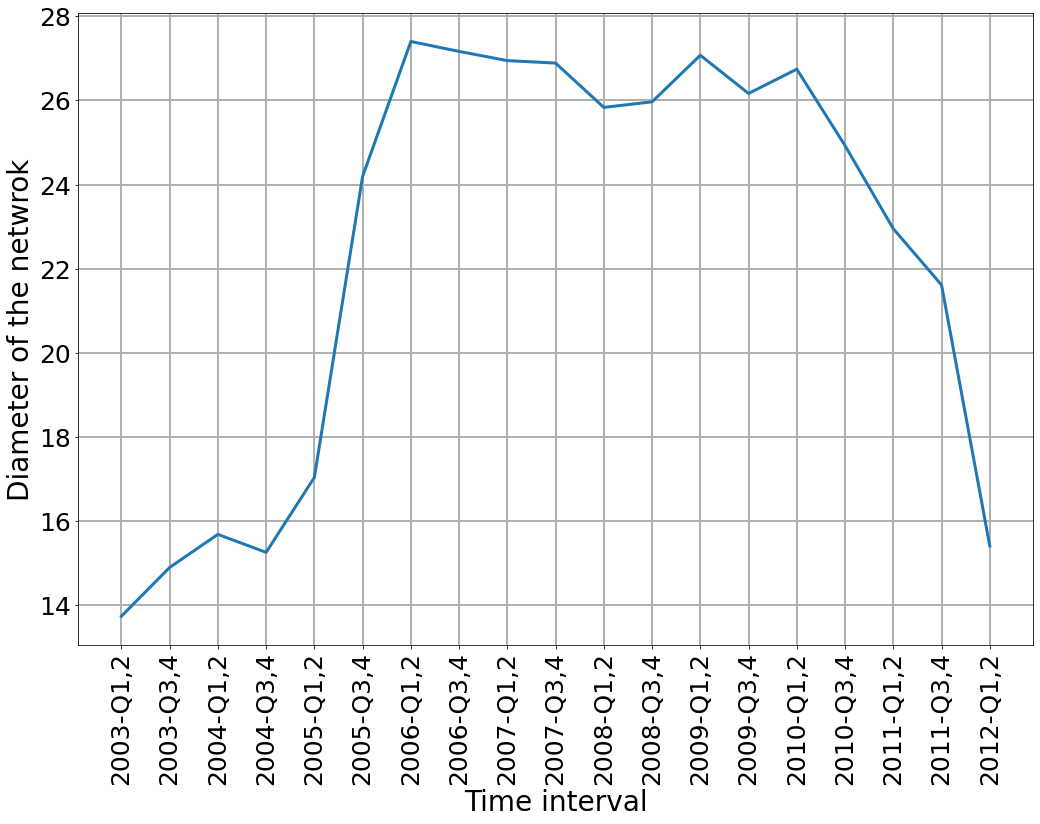

In [48]:
namelist = ['2003-Q1,2',
            '2003-Q3,4',
           '2004-Q1,2',
            '2004-Q3,4',
           '2005-Q1,2',
            '2005-Q3,4',
           '2006-Q1,2',
            '2006-Q3,4',
           '2007-Q1,2',
            '2007-Q3,4',
           '2008-Q1,2',
            '2008-Q3,4',
           '2009-Q1,2',
            '2009-Q3,4',
           '2010-Q1,2',
            '2010-Q3,4',
           '2011-Q1,2',
            '2011-Q3,4',
           '2012-Q1,2']
plt.plot(range(0, len(diam)), diam, linewidth = 3)
plt.xticks(range(0, len(diam)), namelist, rotation = 90)
plt.xlabel('Time interval', fontsize = 28)
plt.ylabel('Diameter of the netwrok', fontsize = 28 )
plt.tight_layout()
plt.grid(linewidth = 2)
plt.savefig('./diameter.pdf')